In [1]:
import sys
sys.path.append('/home/iaw/MYscrip/WatAna')
import os

In [2]:
from util.traj_xyz import *
from util.auto_corr_fft import *
from util.auto_corr_to_Iw import *

# 加载实验数据

In [3]:
exp_data = np.loadtxt("./data/exp_h2o.csv", delimiter=",")

# 计算45ps PBE AIMD获取的数据

In [4]:
dt = 0.0005   # ps
if not os.path.exists('./out/pbe_qv_3d_45ps.npy'):
    # 读取轨迹, 并计算qv
    xyz_fp = "/home/iaw/DATA/csw_wat_pbe/water-pos-1.xyz"
    n_reads = 90000
                   
    # 其实读取的会多1, 这样输出的速度就会是是原来的n_reads
    n_reads += 1

    coor_s = read_coor_from_xyz(xyz_fp, n_reads)
    v_s = cal_v_from_coor(coor_s, dt)

    # 这里生成一个q的张量, 形状等同于n_frames, n_atoms, 3
    q_s = np.zeros(shape = v_s.shape)

    for i in range(0, v_s.shape[1], 3):
        q_s[:, i, :] = -2     # O 原子
        q_s[:, i+1, :] = 1  # H 原子
        q_s[:, i+2, :] = 1  # H 原子

    qv_s = v_s * q_s

    # 所有原子加和
    qv_s_total = qv_s.sum(axis = 1)
    print(qv_s_total.shape)
    np.save('./out/pbe_qv_3d_45ps.npy', qv_s_total, allow_pickle=True)

qv_s_total = np.load("./out/pbe_qv_3d_45ps.npy")
C_qv = auto_corr_fft(qv_s_total, fraction_autocorrelation_function_to_fft = 0.1)
tau = np.array(np.array(list(range(C_qv.shape[0])), dtype=np.float64))
tau *= dt                   # ps
# save
with open("./out/qv_autocorr_out_PBE_45ps.csv", "w+") as F:
    for i, i_x in enumerate(tau):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, C_qv[i]))
qv_autocorr_pbe_45ps = np.loadtxt("./out/qv_autocorr_out_PBE_45ps.csv",delimiter=",")
qv_autocorr_pbe_45ps_hann = auto_corr_hann(qv_autocorr_pbe_45ps[:,1])
Iw_pbe_45ps_hann = fft_to_Iw(qv_autocorr_pbe_45ps[:,0], qv_autocorr_pbe_45ps_hann)
Iw_pbe_45ps_wohann = fft_to_Iw(qv_autocorr_pbe_45ps[:,0], qv_autocorr_pbe_45ps[:,1])


In [10]:
x, y1 = Iw_pbe_45ps_hann
_, y2 = Iw_pbe_45ps_wohann
with open("./out/ir-pbe-45ps.csv", "w+") as F:
    F.writelines("Freq, Iw(45ps, hann), Iw(45ps, w/o hann)\n")
    for i, i_x in enumerate(x):
        F.writelines("{:.6f}, {:.6f}, {:.6f}\n".format(i_x, y1[i], y2[i]))


## 对比一下Hann窗对光谱质量的影响

In [5]:
from matplotlib import pyplot as plt 
import matplotlib.ticker as ticker

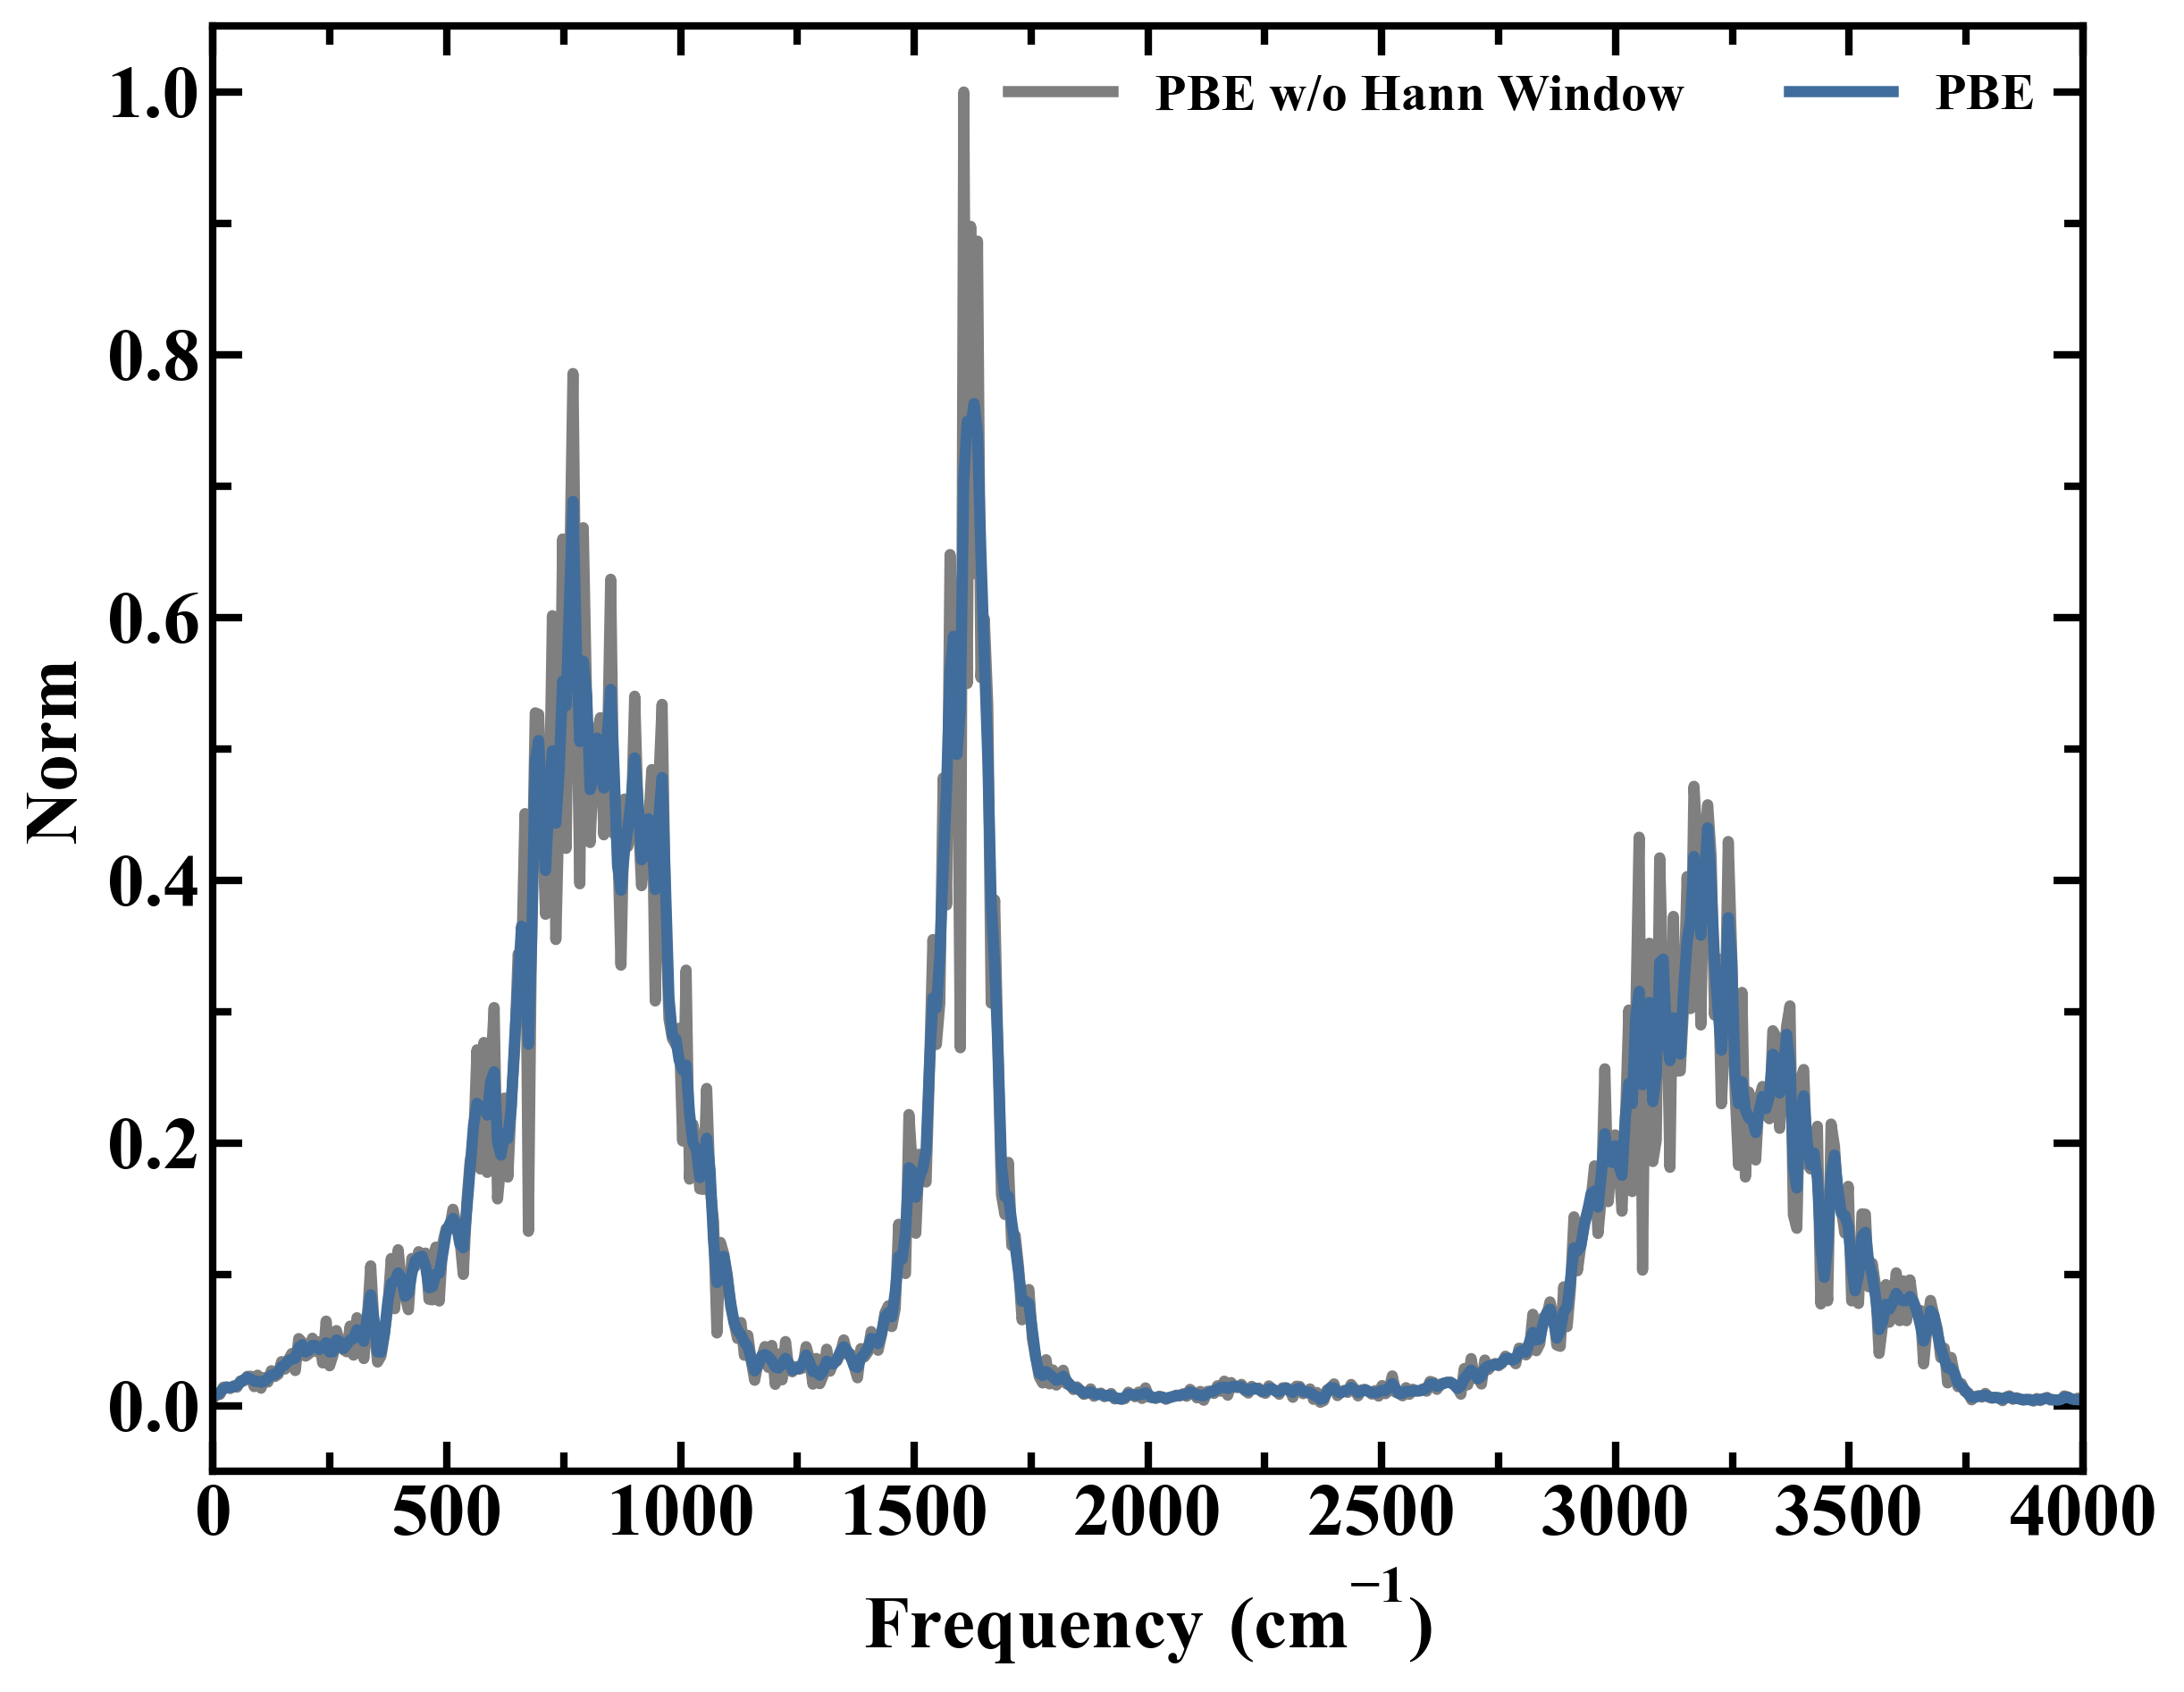

In [7]:
fig = plt.figure(figsize=(9,7),dpi=300)

plt.rcParams["axes.labelweight"] ="bold" 
plt.rcParams["font.family"]="Times New Roman" 
plt.rcParams["font.weight"]="bold" 
plt.rcParams["font.size"]=14 
plt.rcParams["mathtext.default"]="regular"

ax1= plt.gca()
ax1.spines['left'].set_position(('axes',0))
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.tick_params(which='major'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=8              # 设置长短
                    ,labelsize=20
 
                    )
ax1.tick_params(which='minor'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=5              # 设置长短
                    ,labelsize=20
           
                    )
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

c_s = ["#b4372c", "#cd8056", "#cfc282", "#bbd2cf", "#78a8c2", "#406d9c"]

_norm_min = min(Iw_pbe_45ps_wohann[1].min(), Iw_pbe_45ps_hann[1].min())
_norm_max = max(Iw_pbe_45ps_wohann[1].max(), Iw_pbe_45ps_hann[1].max())

Iw_pbe_45ps_wohann_norm = (Iw_pbe_45ps_wohann[1] - _norm_min)/(_norm_max - _norm_min)
ax1.plot(Iw_pbe_45ps_wohann[0], Iw_pbe_45ps_wohann_norm
         , label="PBE w/o Hann Window"
         , c = "black"
         , alpha = 0.5,linewidth=3, linestyle = "-")  

Iw_pbe_45ps_hann_norm = (Iw_pbe_45ps_hann[1] - _norm_min)/(_norm_max - _norm_min)
ax1.plot(Iw_pbe_45ps_hann[0], Iw_pbe_45ps_hann_norm
         , label="PBE"
         , c = c_s[-1]
         , alpha = 1,linewidth=3, linestyle = "-") 

plt.xlim([0, 4000])

plt.legend(frameon=False, ncol=2)
plt.xlabel(r"$Frequency\ (cm^{-1})$", fontsize=20)
plt.ylabel(r"Norm", fontsize=20)
plt.savefig("1_pbe.png", dpi = 300)

# 计算20 ps PBE AIMD获取的数据

In [12]:
dt = 0.0005   # ps
if not os.path.exists('./out/pbe_qv_3d_20ps.npy'):
    # 读取轨迹, 并计算qv
    xyz_fp = "/home/iaw/DATA/csw_wat_pbe/water-pos-1.xyz"
    n_reads = 40000
                   
    # 其实读取的会多1, 这样输出的速度就会是是原来的n_reads
    n_reads += 1

    coor_s = read_coor_from_xyz(xyz_fp, n_reads)
    v_s = cal_v_from_coor(coor_s, dt)

    # 这里生成一个q的张量, 形状等同于n_frames, n_atoms, 3
    q_s = np.zeros(shape = v_s.shape)

    for i in range(0, v_s.shape[1], 3):
        q_s[:, i, :] = -2     # O 原子
        q_s[:, i+1, :] = 1  # H 原子
        q_s[:, i+2, :] = 1  # H 原子

    qv_s = v_s * q_s

    # 所有原子加和
    qv_s_total = qv_s.sum(axis = 1)
    print(qv_s_total.shape)
    np.save('./out/pbe_qv_3d_20ps.npy', qv_s_total, allow_pickle=True)

qv_s_total = np.load("./out/pbe_qv_3d_20ps.npy")
C_qv = auto_corr_fft(qv_s_total, fraction_autocorrelation_function_to_fft = 0.1)
tau = np.array(np.array(list(range(C_qv.shape[0])), dtype=np.float64))
tau *= dt                   # ps
# save
with open("./out/qv_autocorr_out_PBE_20ps.csv", "w+") as F:
    for i, i_x in enumerate(tau):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, C_qv[i]))
qv_autocorr_pbe_20ps = np.loadtxt("./out/qv_autocorr_out_PBE_20ps.csv",delimiter=",")
qv_autocorr_pbe_20ps_hann = auto_corr_hann(qv_autocorr_pbe_20ps[:,1])
Iw_pbe_20ps_hann = fft_to_Iw(qv_autocorr_pbe_20ps[:,0], qv_autocorr_pbe_20ps_hann)

In [13]:
x, y3 = Iw_pbe_20ps_hann
with open("./out/ir-pbe-20ps.csv", "w+") as F:
    F.writelines("Freq, Iw(20ps, hann)\n")
    for i, i_x in enumerate(x):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, y3[i]))


## 比较一下不同采样时间对光谱质量的影响

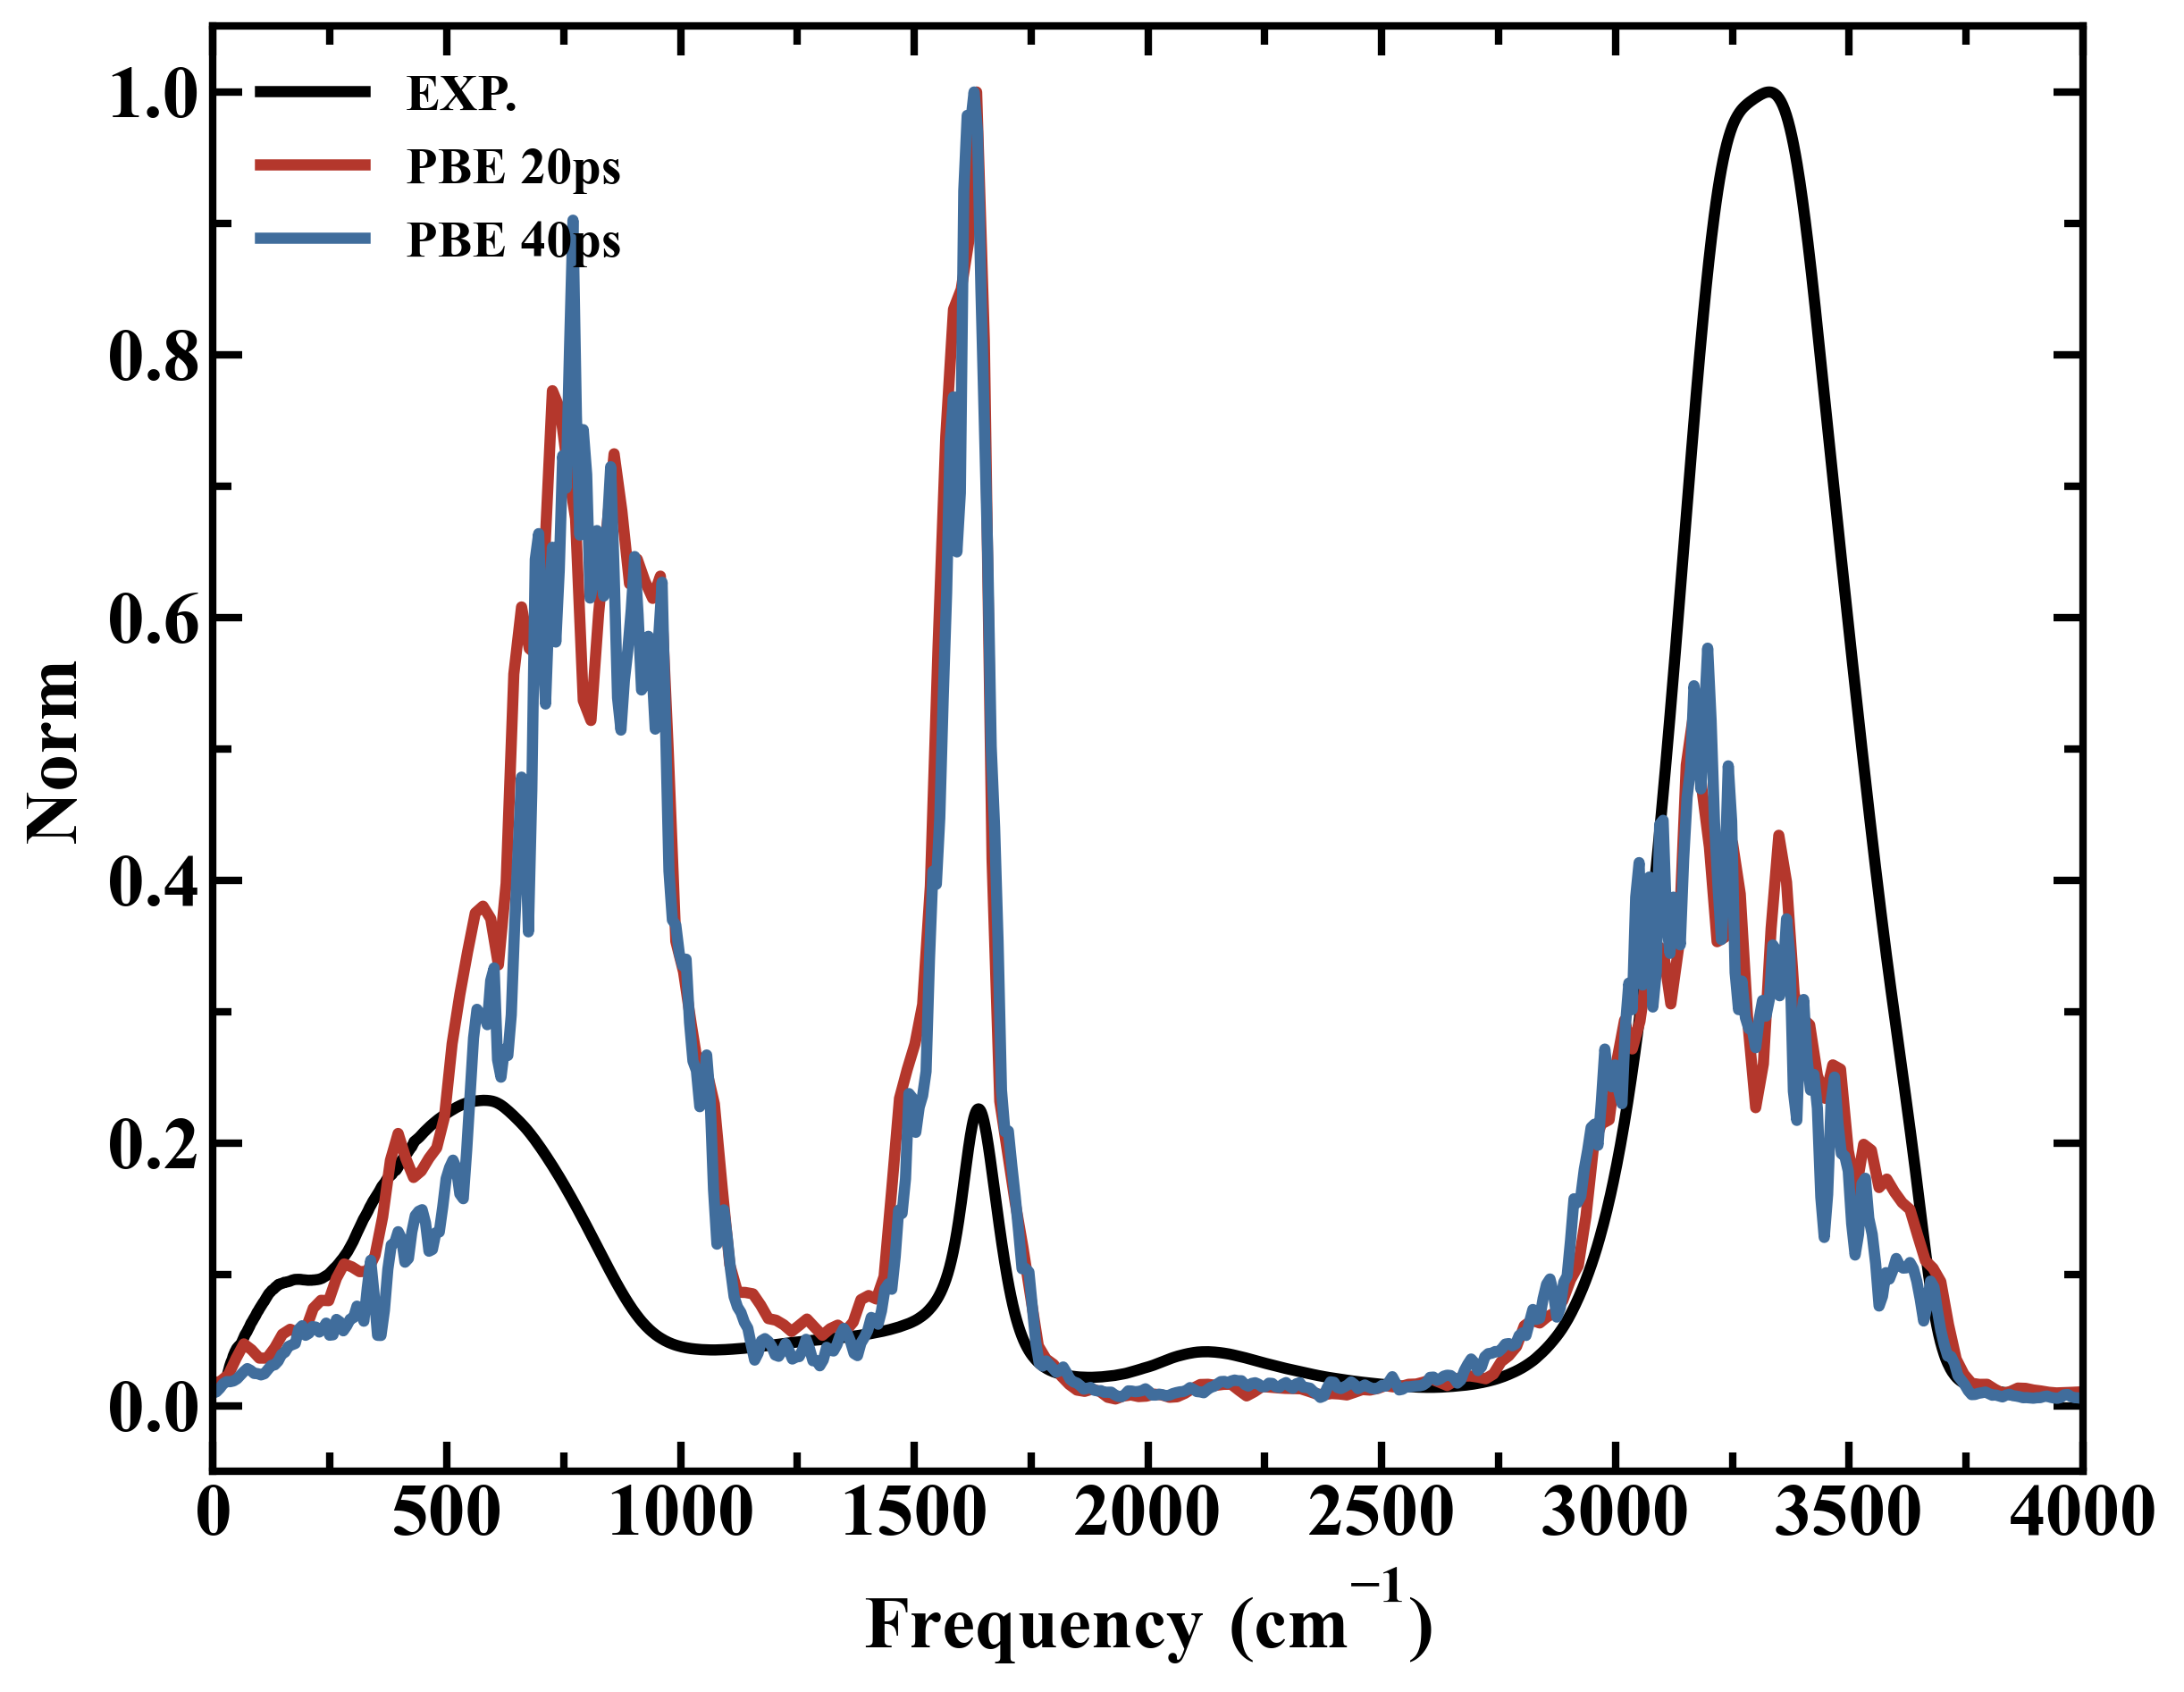

In [9]:
fig = plt.figure(figsize=(9,7),dpi=300)

plt.rcParams["axes.labelweight"] ="bold" 
plt.rcParams["font.family"]="Times New Roman" 
plt.rcParams["font.weight"]="bold" 
plt.rcParams["font.size"]=14 
plt.rcParams["mathtext.default"]="regular"

ax1= plt.gca()
ax1.spines['left'].set_position(('axes',0))
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.tick_params(which='major'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=8              # 设置长短
                    ,labelsize=20
 
                    )
ax1.tick_params(which='minor'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=5              # 设置长短
                    ,labelsize=20
           
                    )
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

c_s = ["#b4372c", "#cd8056", "#cfc282", "#bbd2cf", "#78a8c2", "#406d9c"]

exp_data_y_norm = (exp_data[:, 1] -exp_data[:, 1].min())/(exp_data[:, 1].max() - exp_data[:, 1].min())
ax1.plot(exp_data[:, 0], exp_data_y_norm
         , label="EXP."
         , c = "black"
         , alpha = 1,linewidth=3, linestyle = "-")  

Iw_pbe_20ps_hann_norm = (Iw_pbe_20ps_hann[1] -Iw_pbe_20ps_hann[1].min())/(Iw_pbe_20ps_hann[1].max() - Iw_pbe_20ps_hann[1].min())
ax1.plot(Iw_pbe_20ps_hann[0], Iw_pbe_20ps_hann_norm
         , label="PBE 20ps"
         , c = c_s[0]
         , alpha = 1,linewidth=3, linestyle = "-")  

Iw_pbe_45ps_hann_norm = (Iw_pbe_45ps_hann[1] -Iw_pbe_45ps_hann[1].min())/(Iw_pbe_45ps_hann[1].max() - Iw_pbe_45ps_hann[1].min())
ax1.plot(Iw_pbe_45ps_hann[0], Iw_pbe_45ps_hann_norm
         , label="PBE 40ps"
         , c = c_s[-1]
         , alpha = 1,linewidth=3, linestyle = "-") 

plt.xlim([0, 4000])

plt.legend(frameon=False, ncol=1)
plt.xlabel(r"$Frequency\ (cm^{-1})$", fontsize=20)
plt.ylabel(r"Norm", fontsize=20)
plt.savefig("2_pbe.png", dpi=300)

# 加载SPCE 数据

## 细节
- 这里采用的柔性水
- 引入qspcfw矫正
- 共包含2558个水分子

In [14]:
import MDAnalysis as mda
from multiprocessing import Pool
from functools import partial

## 200 ps

In [15]:
dt = 0.0005   # ps
if not os.path.exists('./out/SPCE_qv_3d_200ps.npy'):
    # 读取轨迹, 并计算qv
    fp_ncdf = "/home/iaw/DATA/ALP/bulk2/nvt-0.5fs/md20ps.ncdf"
    fp_top = "/home/iaw/DATA/ALP/bulk2/nvt-0.5fs/model.prmtop"
    start_frame = 0
    end_frame = 400000
    step = 1
    sele_mask = "type OW"
    O_charge = -0.84
    H_charge = 0.42
    n_worker = 10

    u = mda.Universe(fp_top,fp_ncdf, dt = dt)
    print("All number of frames is {}, and the timestep is {:.4f} ps, and the simulation time is {:.4f} ns".format(len(u.trajectory)
                                , u.trajectory.dt
                                , len(u.trajectory) * u.trajectory.dt / 1000))
    
    def get_QV(i_frame, u, sele_mask, O_charge = False, H_charge = False):

        total_u_ = np.zeros(shape=(3,))

        i_traj = u.trajectory[i_frame]
        i_v = i_traj.velocities
        seles = u.select_atoms(sele_mask) 

        # 这里是取巧, 水分子储存的时候是按照顺序
        ow_idx = seles.indices
        hw1_idx = seles.indices+1
        hw2_idx = seles.indices+2

        #n_atm, 3 -> 3, 1
        qv_ow = i_v[ow_idx].sum(axis = 0)*O_charge
        qv_hw1 = i_v[hw1_idx].sum(axis = 0)*H_charge
        qv_hw2 = i_v[hw2_idx].sum(axis = 0)*H_charge
        total_u_ += (qv_ow + qv_hw1 + qv_hw2)
        return total_u_

    single_frame = partial(get_QV
                , u = u
                , sele_mask = sele_mask
                , O_charge = O_charge, H_charge = H_charge)
    
    frames = list(range(start_frame,end_frame,step))

    # 这种任务, 实际上并行的效率并不是很高, 一定要注意内存
    with Pool(n_worker) as worker_pool:
        result = worker_pool.map(single_frame, frames)

    qv_s_total = np.stack(result, axis = 0)
    print(qv_s_total.shape)
    np.save('./out/SPCE_qv_3d_200ps.npy', qv_s_total, allow_pickle=True)

qv_s_total = np.load("./out/SPCE_qv_3d_200ps.npy")
C_qv = auto_corr_fft(qv_s_total, fraction_autocorrelation_function_to_fft = 0.1)
tau = np.array(np.array(list(range(C_qv.shape[0])), dtype=np.float64))
tau *= dt                   # ps
# save
with open("./out/qv_autocorr_out_SPCE_200ps.csv", "w+") as F:
    for i, i_x in enumerate(tau):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, C_qv[i]))
qv_autocorr_SPCE_200ps = np.loadtxt("./out/qv_autocorr_out_SPCE_200ps.csv",delimiter=",")
qv_autocorr_SPCE_200ps_hann = auto_corr_hann(qv_autocorr_SPCE_200ps[:,1])
Iw_SPCE_200ps_hann = fft_to_Iw(qv_autocorr_SPCE_200ps[:,0], qv_autocorr_SPCE_200ps_hann)


## 100 ps 

In [16]:
dt = 0.0005   # ps
if not os.path.exists('./out/SPCE_qv_3d_100ps.npy'):
    # 读取轨迹, 并计算qv
    fp_ncdf = "/home/iaw/DATA/ALP/bulk2/nvt-0.5fs/md20ps.ncdf"
    fp_top = "/home/iaw/DATA/ALP/bulk2/nvt-0.5fs/model.prmtop"
    start_frame = 0
    end_frame = 200000
    step = 1       
    sele_mask = "type OW"
    O_charge = -0.84
    H_charge = 0.42
    n_worker = 20

    u = mda.Universe(fp_top,fp_ncdf, dt = dt)
    print("All number of frames is {}, and the timestep is {:.4f} ps, and the simulation time is {:.4f} ns".format(len(u.trajectory)
                                , u.trajectory.dt
                                , len(u.trajectory) * u.trajectory.dt / 1000))
    
    def get_QV(i_frame, u,sele_mask, O_charge = False, H_charge = False):

        total_u_ = np.zeros(shape=(3,))

        i_traj = u.trajectory[i_frame]
        i_v = i_traj.velocities
        seles = u.select_atoms(sele_mask) 

        # 这里是取巧, 水分子储存的时候是按照顺序
        ow_idx = seles.indices
        hw1_idx = seles.indices+1
        hw2_idx = seles.indices+2

        #n_atm, 3 -> 3, 1
        qv_ow = i_v[ow_idx].sum(axis = 0)*O_charge
        qv_hw1 = i_v[hw1_idx].sum(axis = 0)*H_charge
        qv_hw2 = i_v[hw2_idx].sum(axis = 0)*H_charge
        total_u_ += (qv_ow + qv_hw1 + qv_hw2)
        return total_u_

    single_frame = partial(get_QV
                , u = u
                , sele_mask = sele_mask
                , O_charge = O_charge, H_charge = H_charge)
    frames = list(range(start_frame,end_frame,step))

    # 这种任务, 实际上并行的效率并不是很高, 一定要注意内存
    with Pool(n_worker) as worker_pool:
        result = worker_pool.map(single_frame, frames)

    qv_s_total = np.stack(result, axis = 0)
    print(qv_s_total.shape)
    np.save('./out/SPCE_qv_3d_100ps.npy', qv_s_total, allow_pickle=True)

qv_s_total = np.load("./out/SPCE_qv_3d_100ps.npy")
C_qv = auto_corr_fft(qv_s_total, fraction_autocorrelation_function_to_fft = 0.1)
tau = np.array(np.array(list(range(C_qv.shape[0])), dtype=np.float64))
tau *= dt                   # ps
# save
with open("./out/qv_autocorr_out_SPCE_100ps.csv", "w+") as F:
    for i, i_x in enumerate(tau):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, C_qv[i]))
qv_autocorr_SPCE_100ps = np.loadtxt("./out/qv_autocorr_out_SPCE_100ps.csv",delimiter=",")
qv_autocorr_SPCE_100ps_hann = auto_corr_hann(qv_autocorr_SPCE_100ps[:,1])
Iw_SPCE_100ps_hann = fft_to_Iw(qv_autocorr_SPCE_100ps[:,0], qv_autocorr_SPCE_100ps_hann)


## 50 ps

In [17]:
dt = 0.0005   # ps
if not os.path.exists('./out/SPCE_qv_3d_50ps.npy'):
    # 读取轨迹, 并计算qv
    fp_ncdf = "/home/iaw/DATA/ALP/bulk2/nvt-0.5fs/md20ps.ncdf"
    fp_top = "/home/iaw/DATA/ALP/bulk2/nvt-0.5fs/model.prmtop"
    start_frame = 0
    end_frame = 100000
    step = 1
    sele_mask = "type OW"
    O_charge = -0.84
    H_charge = 0.42
    n_worker = 20

    u = mda.Universe(fp_top,fp_ncdf, dt = dt)
    print("All number of frames is {}, and the timestep is {:.4f} ps, and the simulation time is {:.4f} ns".format(len(u.trajectory)
                                , u.trajectory.dt
                                , len(u.trajectory) * u.trajectory.dt / 1000))
    
    def get_QV(i_frame, u,sele_mask, O_charge = False, H_charge = False):

        total_u_ = np.zeros(shape=(3,))

        i_traj = u.trajectory[i_frame]
        i_v = i_traj.velocities
        seles = u.select_atoms(sele_mask) 

        # 这里是取巧, 水分子储存的时候是按照顺序
        ow_idx = seles.indices
        hw1_idx = seles.indices+1
        hw2_idx = seles.indices+2

        #n_atm, 3 -> 3, 1
        qv_ow = i_v[ow_idx].sum(axis = 0)*O_charge
        qv_hw1 = i_v[hw1_idx].sum(axis = 0)*H_charge
        qv_hw2 = i_v[hw2_idx].sum(axis = 0)*H_charge
        total_u_ += (qv_ow + qv_hw1 + qv_hw2)
        return total_u_

    single_frame = partial(get_QV
                , u = u
                , sele_mask = sele_mask
                , O_charge = O_charge, H_charge = H_charge)
    frames = list(range(start_frame,end_frame,step))

    # 这种任务, 实际上并行的效率并不是很高, 一定要注意内存
    with Pool(n_worker) as worker_pool:
        result = worker_pool.map(single_frame, frames)

    qv_s_total = np.stack(result, axis = 0)
    print(qv_s_total.shape)
    np.save('./out/SPCE_qv_3d_50ps.npy', qv_s_total, allow_pickle=True)

qv_s_total = np.load("./out/SPCE_qv_3d_50ps.npy")
C_qv = auto_corr_fft(qv_s_total, fraction_autocorrelation_function_to_fft = 0.1)
tau = np.array(np.array(list(range(C_qv.shape[0])), dtype=np.float64))
tau *= dt                   # ps
# save
with open("./out/qv_autocorr_out_SPCE_50ps.csv", "w+") as F:
    for i, i_x in enumerate(tau):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, C_qv[i]))
qv_autocorr_SPCE_50ps = np.loadtxt("./out/qv_autocorr_out_SPCE_50ps.csv",delimiter=",")
qv_autocorr_SPCE_50ps_hann = auto_corr_hann(qv_autocorr_SPCE_50ps[:,1])
Iw_SPCE_50ps_hann = fft_to_Iw(qv_autocorr_SPCE_50ps[:,0], qv_autocorr_SPCE_50ps_hann)


In [30]:
x, y6 = Iw_SPCE_50ps_hann
_, y4 = Iw_SPCE_200ps_hann
_, y5 = Iw_SPCE_100ps_hann
with open("./out/ir-spce_qspcfw-ps.csv", "w+") as F:
    F.writelines("Freq, Iw(200ps, hann), Iw(100ps, hann), Iw(50ps, hann)\n")
    for i, i_x in enumerate(x):
        F.writelines("{:.6f}, {:.6f}, {:.6f}, {:.6f}\n".format(i_x, y4[i], y5[i], y6[i]))


## 比较一下不同采样时间对光谱质量的影响

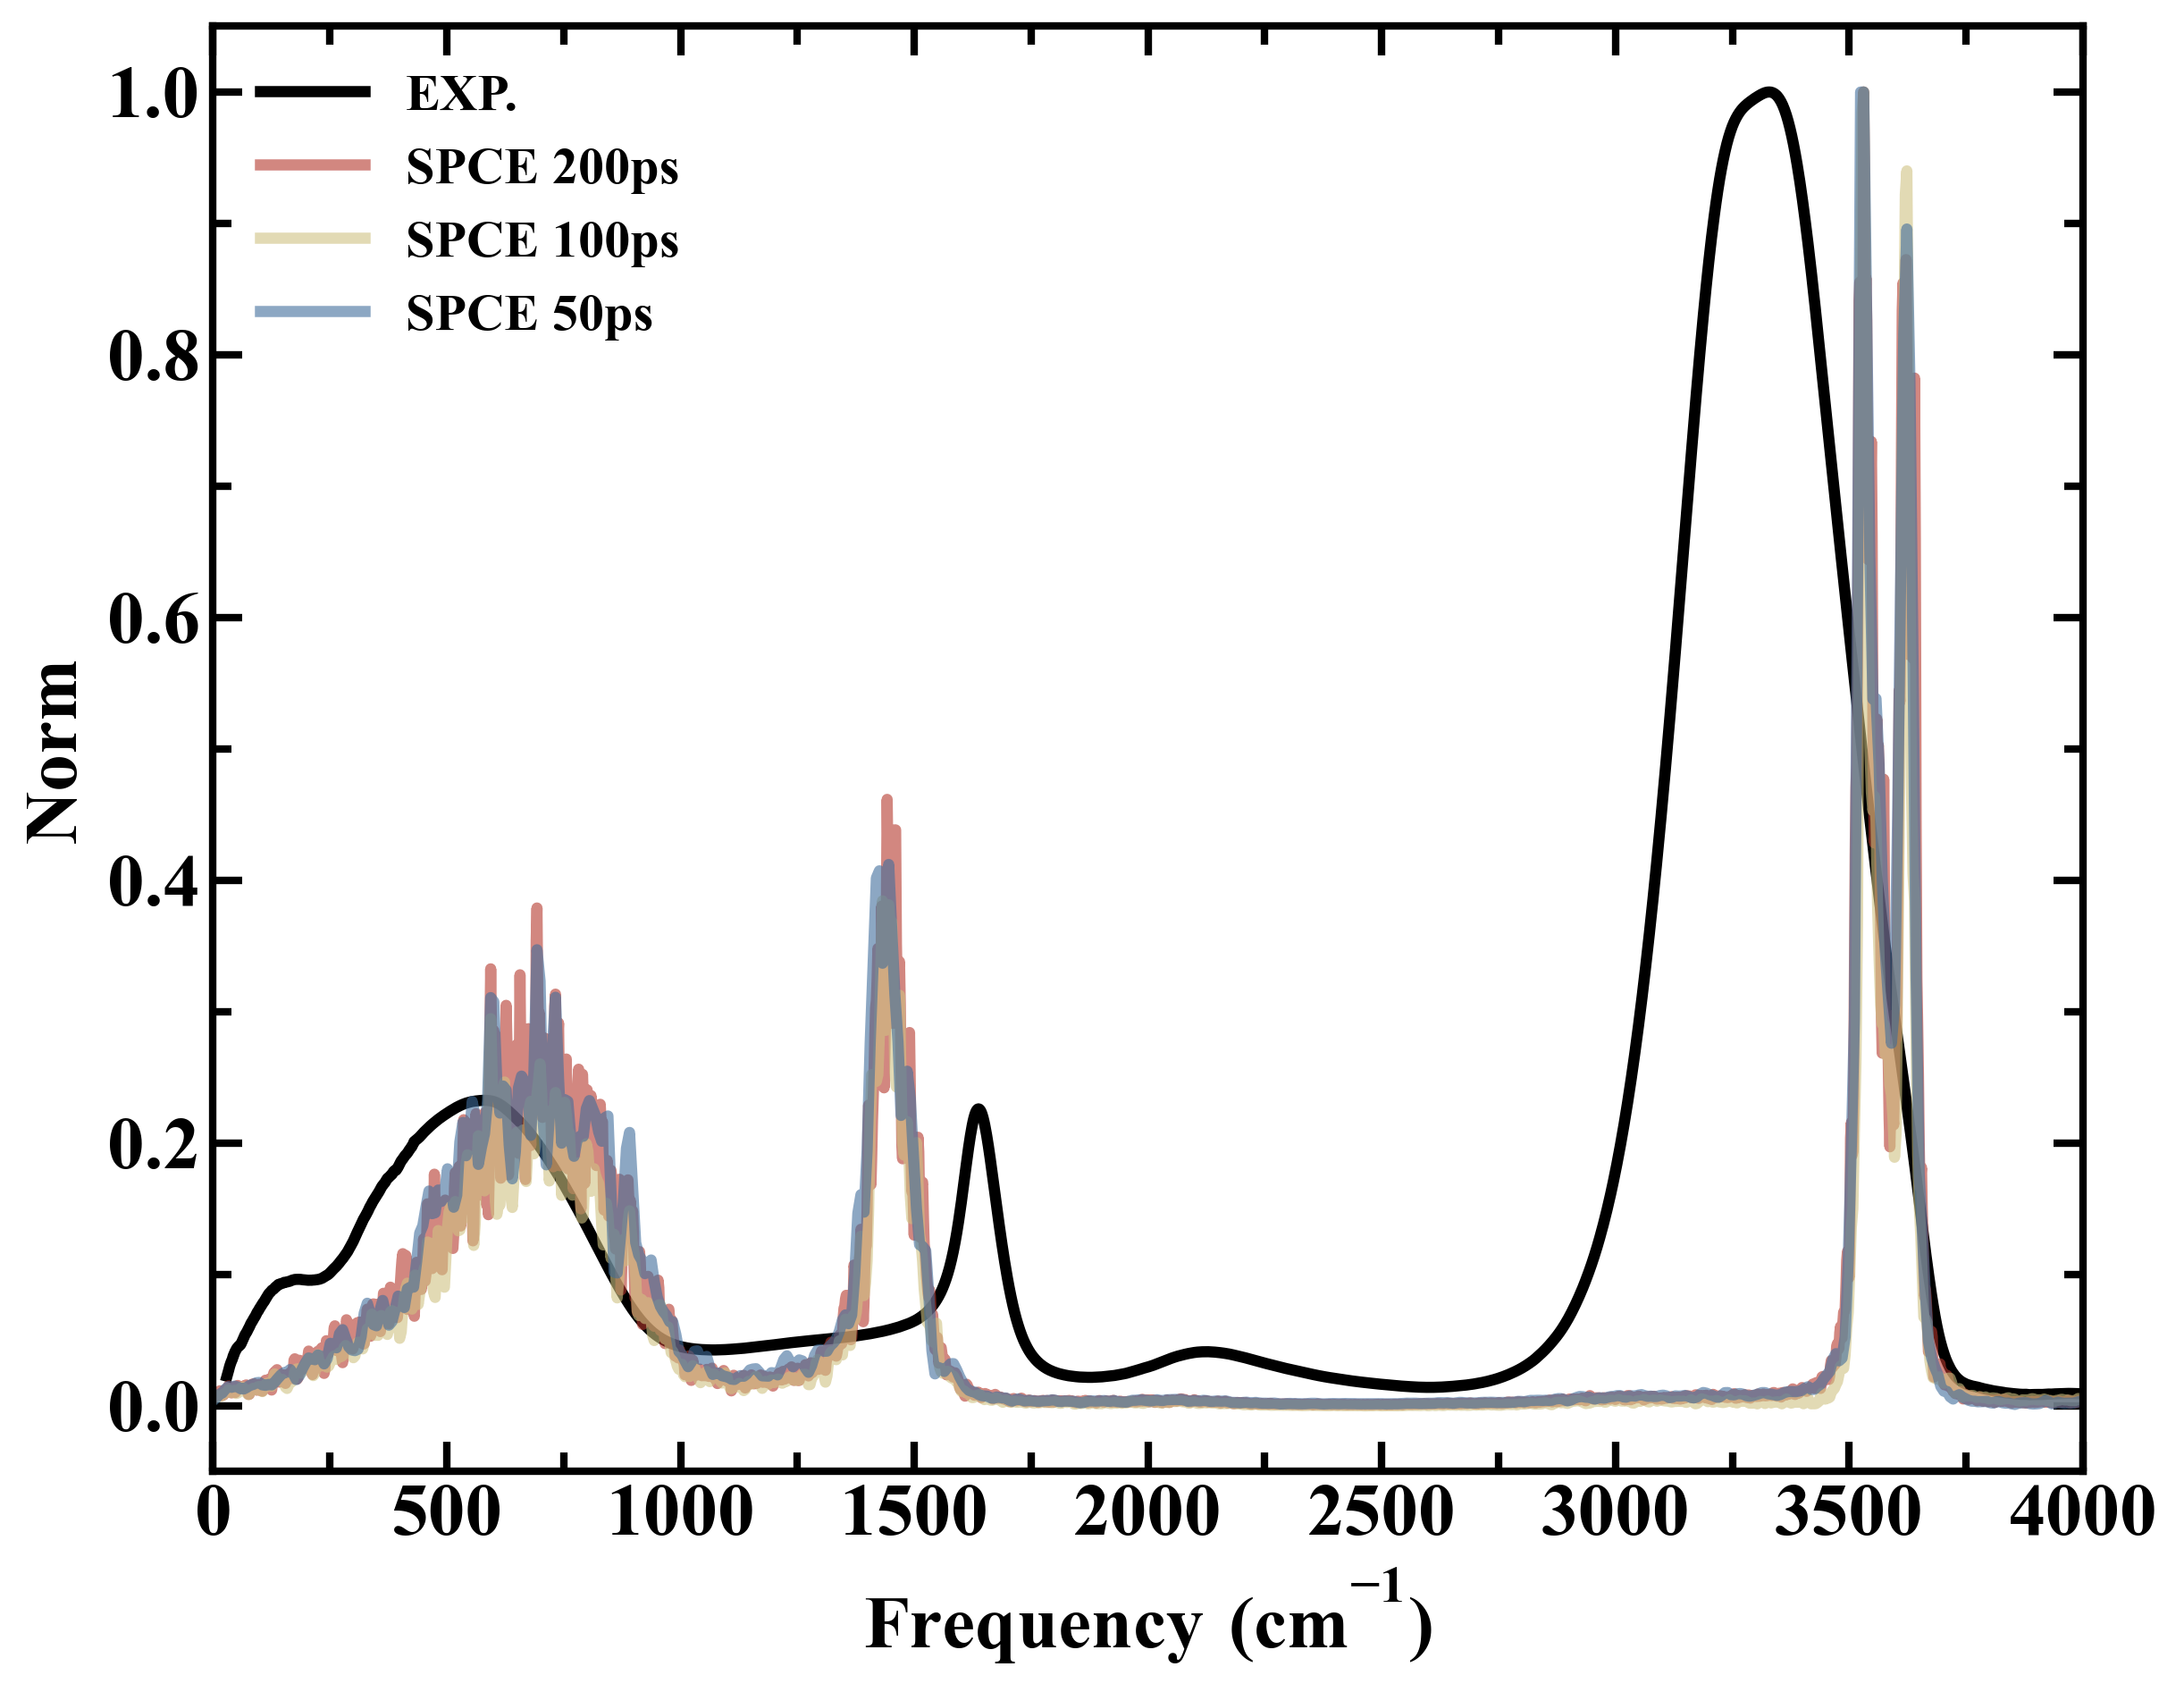

In [14]:
fig = plt.figure(figsize=(9,7),dpi=300)

plt.rcParams["axes.labelweight"] ="bold" 
plt.rcParams["font.family"]="Times New Roman" 
plt.rcParams["font.weight"]="bold" 
plt.rcParams["font.size"]=14 
plt.rcParams["mathtext.default"]="regular"

ax1= plt.gca()
ax1.spines['left'].set_position(('axes',0))
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.tick_params(which='major'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=8              # 设置长短
                    ,labelsize=20
 
                    )
ax1.tick_params(which='minor'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=5              # 设置长短
                    ,labelsize=20
           
                    )
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

c_s = ["#b4372c", "#cd8056", "#cfc282", "#bbd2cf", "#78a8c2", "#406d9c"]

exp_data_y_norm = (exp_data[:, 1] -exp_data[:, 1].min())/(exp_data[:, 1].max() - exp_data[:, 1].min())
ax1.plot(exp_data[:, 0], exp_data_y_norm
         , label="EXP."
         , c = "black"
         , alpha = 1,linewidth=3, linestyle = "-")  

Iw_SPCE_200ps_hann_norm = (Iw_SPCE_200ps_hann[1] -Iw_SPCE_200ps_hann[1].min())/(Iw_SPCE_200ps_hann[1].max() - Iw_SPCE_200ps_hann[1].min())
ax1.plot(Iw_SPCE_200ps_hann[0], Iw_SPCE_200ps_hann_norm
         , label="SPCE 200ps"
         , c = c_s[0]
         , alpha = 0.6,linewidth=3, linestyle = "-")  

Iw_SPCE_100ps_hann_norm = (Iw_SPCE_100ps_hann[1] -Iw_SPCE_100ps_hann[1].min())/(Iw_SPCE_100ps_hann[1].max() - Iw_SPCE_100ps_hann[1].min())
ax1.plot(Iw_SPCE_100ps_hann[0], Iw_SPCE_100ps_hann_norm
         , label="SPCE 100ps"
         , c = c_s[2]
         , alpha = 0.6,linewidth=3, linestyle = "-")  

Iw_SPCE_50ps_hann_norm = (Iw_SPCE_50ps_hann[1] -Iw_SPCE_50ps_hann[1].min())/(Iw_SPCE_50ps_hann[1].max() - Iw_SPCE_50ps_hann[1].min())
ax1.plot(Iw_SPCE_50ps_hann[0], Iw_SPCE_50ps_hann_norm
         , label="SPCE 50ps"
         , c = c_s[-1]
         , alpha = 0.6,linewidth=3, linestyle = "-")  
plt.xlim([0, 4000])

plt.legend(frameon=False, ncol=1)
plt.xlabel(r"$Frequency\ (cm^{-1})$", fontsize=20)
plt.ylabel(r"Norm", fontsize=20)
plt.savefig("3_spce_flex.png", dpi=300)

# 加载SPCE spcfw柔性水模型

In [22]:
dt = 0.0005   # ps
if not os.path.exists('./out/SPCE_spcfw_qv_3d_200ps.npy'):
    # 读取轨迹, 并计算qv
    fp_ncdf = "/home/iaw/DATA2/wat_md/bulk_spce_flex_spcfw/nvt_200ps/md200ps.ncdf"
    fp_top = "/home/iaw/DATA2/wat_md/bulk_spce_flex_spcfw/nvt_200ps/model.prmtop"
    start_frame = 0
    end_frame = 400000
    step = 1
    sele_mask = "type OW"
    O_charge = -0.84
    H_charge = 0.42
    n_worker = 10

    u = mda.Universe(fp_top,fp_ncdf, dt = dt)
    print("All number of frames is {}, and the timestep is {:.4f} ps, and the simulation time is {:.4f} ns".format(len(u.trajectory)
                                , u.trajectory.dt
                                , len(u.trajectory) * u.trajectory.dt / 1000))
    
    def get_QV(i_frame, u, sele_mask, O_charge = False, H_charge = False):

        total_u_ = np.zeros(shape=(3,))

        i_traj = u.trajectory[i_frame]
        i_v = i_traj.velocities
        seles = u.select_atoms(sele_mask) 

        # 这里是取巧, 水分子储存的时候是按照顺序
        ow_idx = seles.indices
        hw1_idx = seles.indices+1
        hw2_idx = seles.indices+2

        #n_atm, 3 -> 3, 1
        qv_ow = i_v[ow_idx].sum(axis = 0)*O_charge
        qv_hw1 = i_v[hw1_idx].sum(axis = 0)*H_charge
        qv_hw2 = i_v[hw2_idx].sum(axis = 0)*H_charge
        total_u_ += (qv_ow + qv_hw1 + qv_hw2)
        return total_u_

    single_frame = partial(get_QV
                , u = u
                , sele_mask = sele_mask
                , O_charge = O_charge, H_charge = H_charge)
    
    frames = list(range(start_frame,end_frame,step))

    # 这种任务, 实际上并行的效率并不是很高, 一定要注意内存
    with Pool(n_worker) as worker_pool:
        result = worker_pool.map(single_frame, frames)

    qv_s_total = np.stack(result, axis = 0)
    print(qv_s_total.shape)
    np.save('./out/SPCE_spcfw_qv_3d_200ps.npy', qv_s_total, allow_pickle=True)

qv_s_total = np.load("./out/SPCE_spcfw_qv_3d_200ps.npy")
C_qv = auto_corr_fft(qv_s_total, fraction_autocorrelation_function_to_fft = 0.1)
tau = np.array(np.array(list(range(C_qv.shape[0])), dtype=np.float64))
tau *= dt                   # ps
# save
with open("./out/qv_autocorr_out_SPCE_spcfw_200ps.csv", "w+") as F:
    for i, i_x in enumerate(tau):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, C_qv[i]))
qv_autocorr_SPCE_spcfw_200ps = np.loadtxt("./out/qv_autocorr_out_SPCE_spcfw_200ps.csv",delimiter=",")
qv_autocorr_SPCE_spcfw_200ps_hann = auto_corr_hann(qv_autocorr_SPCE_spcfw_200ps[:,1])
Iw_SPCE_spcfw_200ps_hann = fft_to_Iw(qv_autocorr_SPCE_spcfw_200ps[:,0], qv_autocorr_SPCE_spcfw_200ps_hann)


In [23]:
x, y7 = Iw_SPCE_spcfw_200ps_hann
with open("./out/ir-spce_spcfw-200ps.csv", "w+") as F:
    F.writelines("Freq, Iw(200ps, hann)\n")
    for i, i_x in enumerate(x):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, y7[i]))


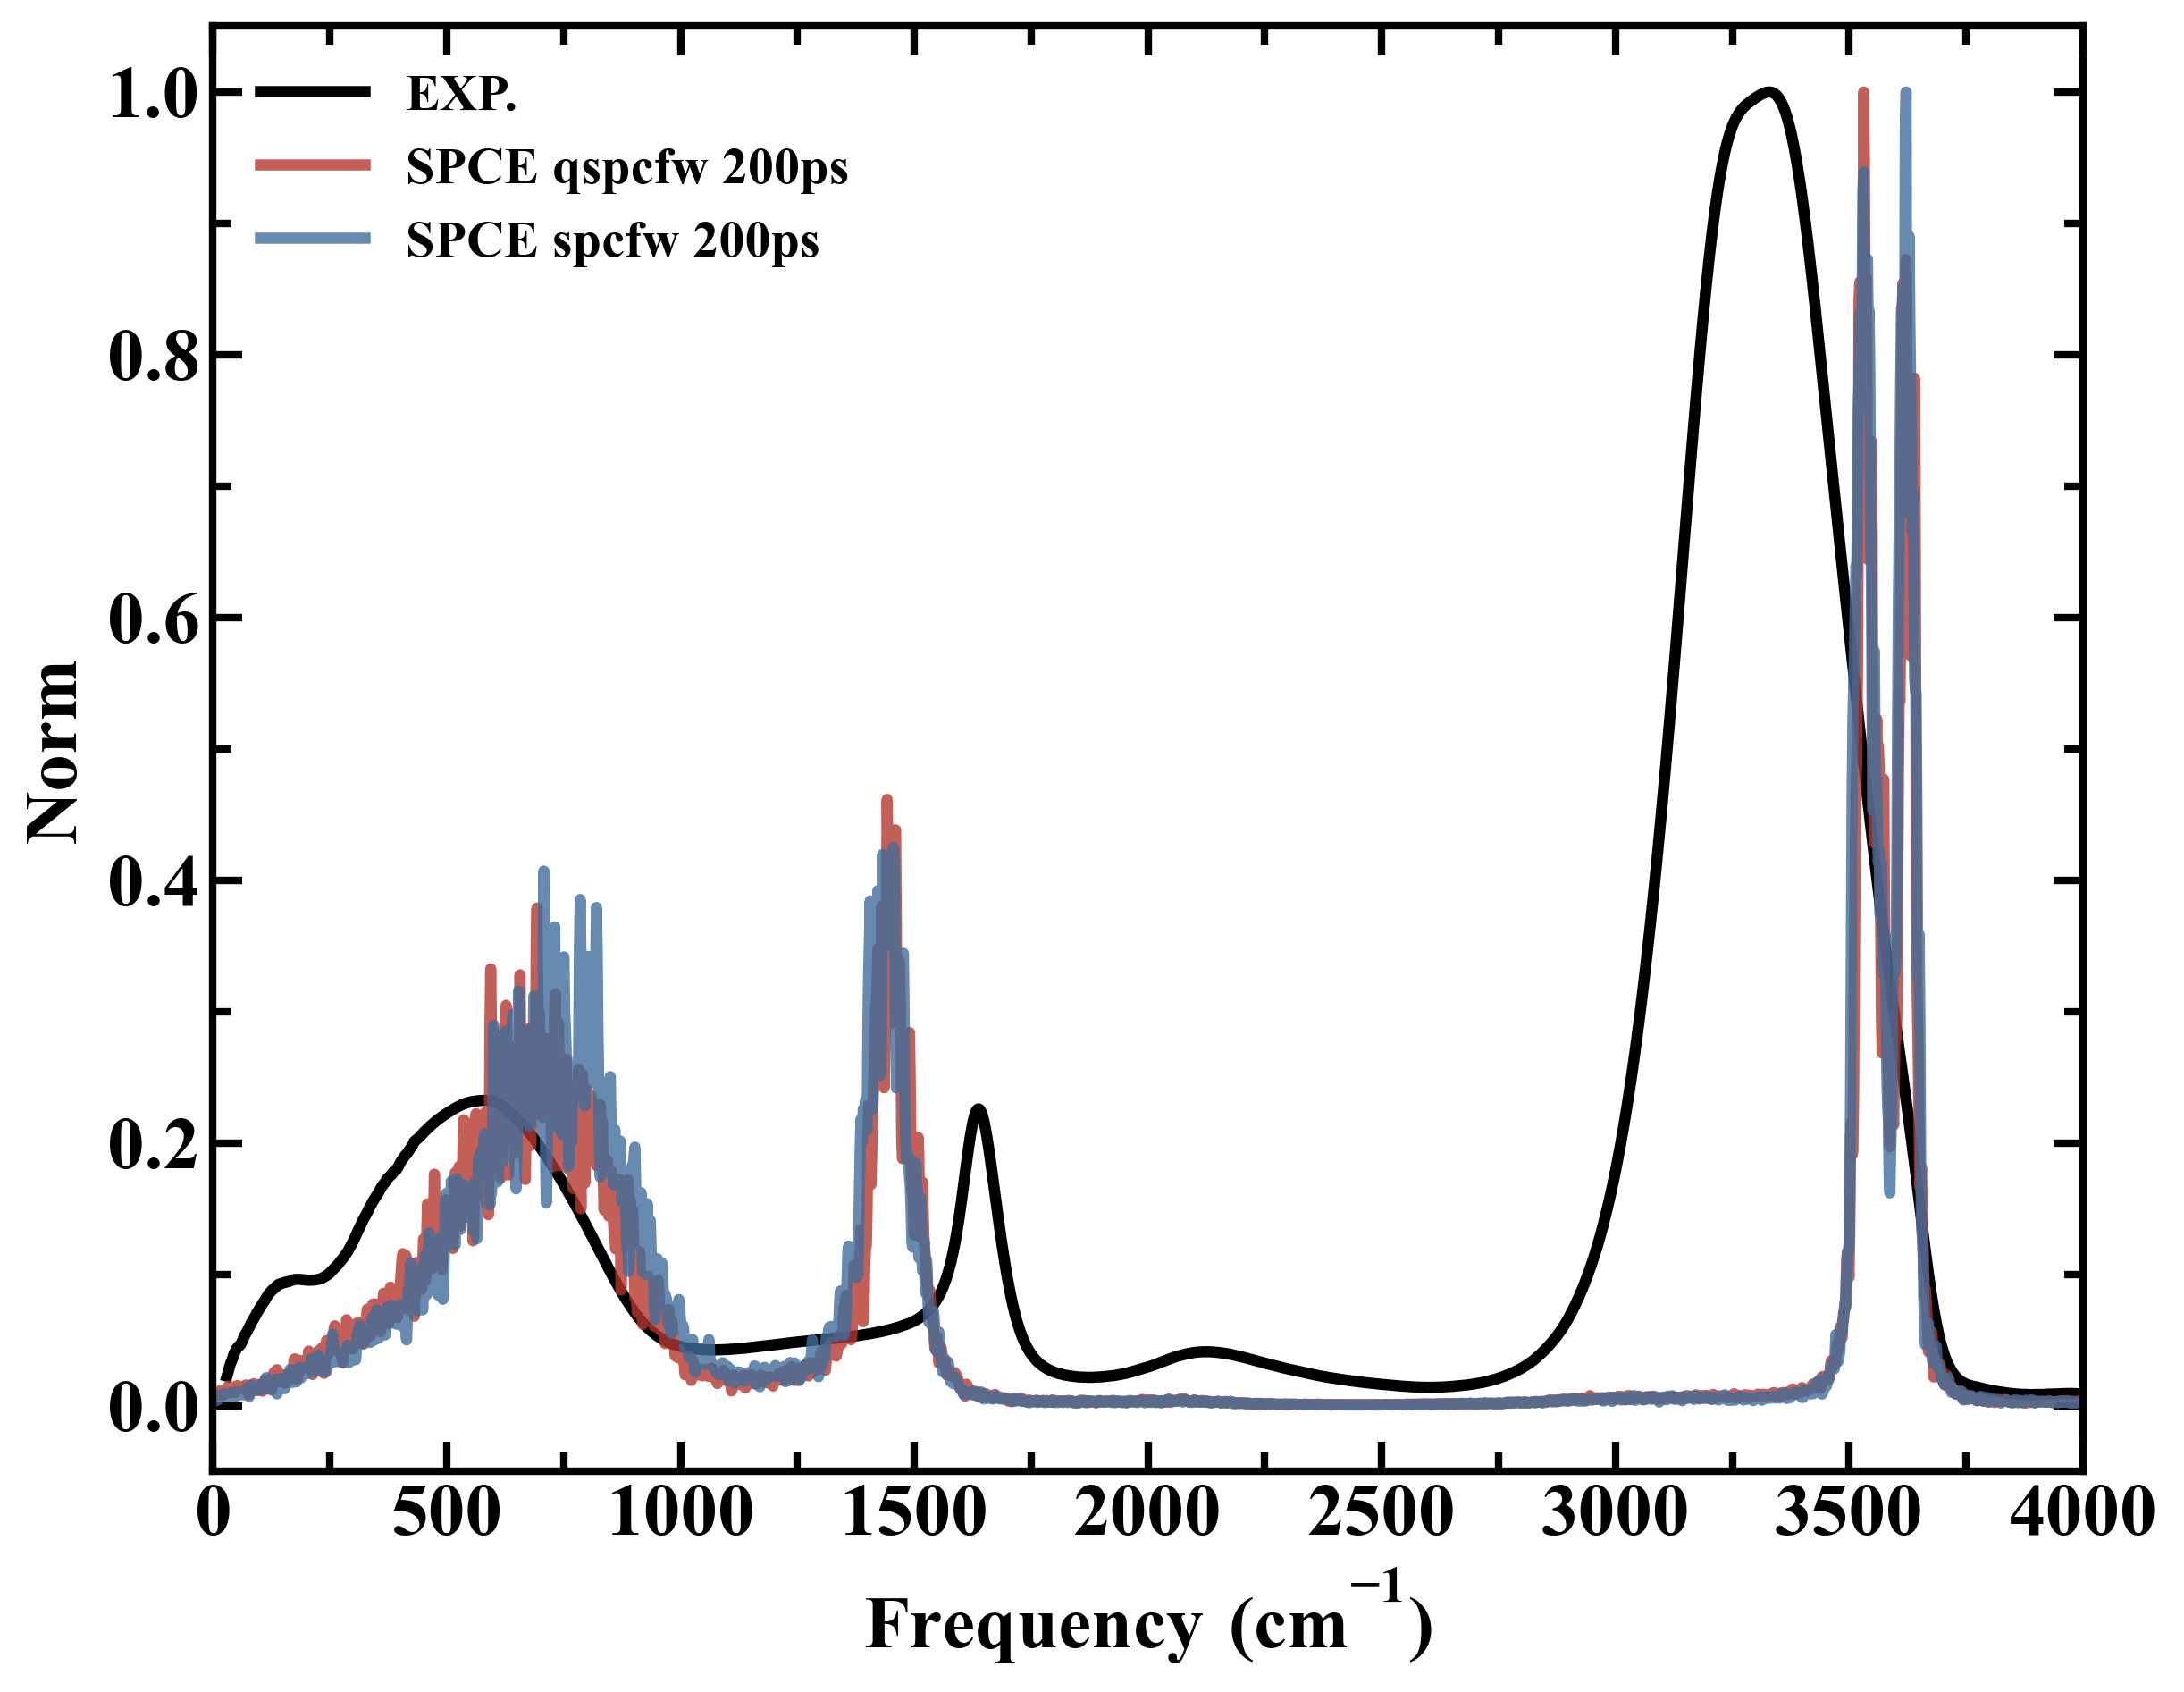

In [52]:
fig = plt.figure(figsize=(9,7),dpi=300)

plt.rcParams["axes.labelweight"] ="bold" 
plt.rcParams["font.family"]="Times New Roman" 
plt.rcParams["font.weight"]="bold" 
plt.rcParams["font.size"]=14 
plt.rcParams["mathtext.default"]="regular"

ax1= plt.gca()
ax1.spines['left'].set_position(('axes',0))
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.tick_params(which='major'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=8              # 设置长短
                    ,labelsize=20
 
                    )
ax1.tick_params(which='minor'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=5              # 设置长短
                    ,labelsize=20
           
                    )
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

c_s = ["#b4372c", "#cd8056", "#cfc282", "#bbd2cf", "#78a8c2", "#406d9c"]

exp_data_y_norm = (exp_data[:, 1] -exp_data[:, 1].min())/(exp_data[:, 1].max() - exp_data[:, 1].min())
ax1.plot(exp_data[:, 0], exp_data_y_norm
         , label="EXP."
         , c = "black"
         , alpha = 1,linewidth=3, linestyle = "-")  

Iw_SPCE_200ps_hann_norm = (Iw_SPCE_200ps_hann[1] -Iw_SPCE_200ps_hann[1].min())/(Iw_SPCE_200ps_hann[1].max() - Iw_SPCE_200ps_hann[1].min())
ax1.plot(Iw_SPCE_200ps_hann[0], Iw_SPCE_200ps_hann_norm
         , label="SPCE qspcfw 200ps"
         , c = c_s[0]
         , alpha = 0.8,linewidth=3, linestyle = "-")  

Iw_SPCE_spcfw_200ps_hann_norm = (Iw_SPCE_spcfw_200ps_hann[1] -Iw_SPCE_spcfw_200ps_hann[1].min())/(Iw_SPCE_spcfw_200ps_hann[1].max() - Iw_SPCE_spcfw_200ps_hann[1].min())
ax1.plot(Iw_SPCE_spcfw_200ps_hann[0], Iw_SPCE_spcfw_200ps_hann_norm
         , label="SPCE spcfw 200ps "
         , c = c_s[-1]
         , alpha = 0.8,linewidth=3, linestyle = "-")  

plt.xlim([0, 4000])

plt.legend(frameon=False, ncol=1)
plt.xlabel(r"$Frequency\ (cm^{-1})$", fontsize=20)
plt.ylabel(r"Norm", fontsize=20)
plt.savefig("3_spce_flex_2.png", dpi=300)

# 加载OPC3POL水模型

## 细节
- 这里采用的刚性水
- 共包含2558个水分子

## 200ps

In [24]:
dt = 0.0005   # ps
if not os.path.exists('./out/OPC3POL_qv_3d_200ps.npy'):
    # 读取轨迹, 并计算qv
    fp_ncdf = "/home/iaw/DATA2/wat_md/bulk_opc3pol_rigid/nvt_200ps/md200ps.ncdf"
    fp_top = "/home/iaw/DATA2/wat_md/bulk_opc3pol_rigid/nvt_200ps/model.prmtop"
    start_frame = 0
    end_frame = 400000
    step = 1
    sele_mask = "type OW"
    O_charge = -1.9321
    H_charge = 0.3052
    Y1_charge = 1.3216
    n_worker = 10

    u = mda.Universe(fp_top,fp_ncdf, dt = dt)
    print("All number of frames is {}, and the timestep is {:.4f} ps, and the simulation time is {:.4f} ns".format(len(u.trajectory)
                                , u.trajectory.dt
                                , len(u.trajectory) * u.trajectory.dt / 1000))
    
    def get_QV(i_frame, u, sele_mask, O_charge = False, H_charge = False, Y_charge = False):

        total_u_ = np.zeros(shape=(3,))

        i_traj = u.trajectory[i_frame]
        i_v = i_traj.velocities
        seles = u.select_atoms(sele_mask) 

        # 这里是取巧, 水分子储存的时候是按照顺序
        ow_idx = seles.indices
        hw1_idx = seles.indices+1
        hw2_idx = seles.indices+2
        y1_idx = seles.indices+3
        #n_atm, 3 -> 3, 1
        qv_ow = i_v[ow_idx].sum(axis = 0)*O_charge
        qv_hw1 = i_v[hw1_idx].sum(axis = 0)*H_charge
        qv_hw2 = i_v[hw2_idx].sum(axis = 0)*H_charge
        qv_y1 = i_v[y1_idx].sum(axis = 0)*Y_charge
        total_u_ += (qv_ow + qv_hw1 + qv_hw2 + qv_y1)
        return total_u_

    single_frame = partial(get_QV
                , u = u
                , sele_mask = sele_mask
                , O_charge = O_charge, H_charge = H_charge, Y_charge = Y1_charge)
    
    frames = list(range(start_frame,end_frame,step))

    # 这种任务, 实际上并行的效率并不是很高, 一定要注意内存
    with Pool(n_worker) as worker_pool:
        result = worker_pool.map(single_frame, frames)

    qv_s_total = np.stack(result, axis = 0)
    print(qv_s_total.shape)
    np.save('./out/OPC3POL_qv_3d_200ps.npy', qv_s_total, allow_pickle=True)

qv_s_total = np.load("./out/OPC3POL_qv_3d_200ps.npy")
C_qv = auto_corr_fft(qv_s_total, fraction_autocorrelation_function_to_fft = 0.1)
tau = np.array(np.array(list(range(C_qv.shape[0])), dtype=np.float64))
tau *= dt                   # ps
# save
with open("./out/qv_autocorr_out_OPC3POL_200ps.csv", "w+") as F:
    for i, i_x in enumerate(tau):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, C_qv[i]))
qv_autocorr_OPC3POL_200ps = np.loadtxt("./out/qv_autocorr_out_OPC3POL_200ps.csv",delimiter=",")
qv_autocorr_OPC3POL_200ps_hann = auto_corr_hann(qv_autocorr_OPC3POL_200ps[:,1])
Iw_OPC3POL_200ps_hann = fft_to_Iw(qv_autocorr_OPC3POL_200ps[:,0], qv_autocorr_OPC3POL_200ps_hann)


In [25]:
x, y8 = Iw_OPC3POL_200ps_hann
with open("./out/ir-opc3pol-200ps.csv", "w+") as F:
    F.writelines("Freq, Iw(200ps, hann)\n")
    for i, i_x in enumerate(x):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, y8[i]))


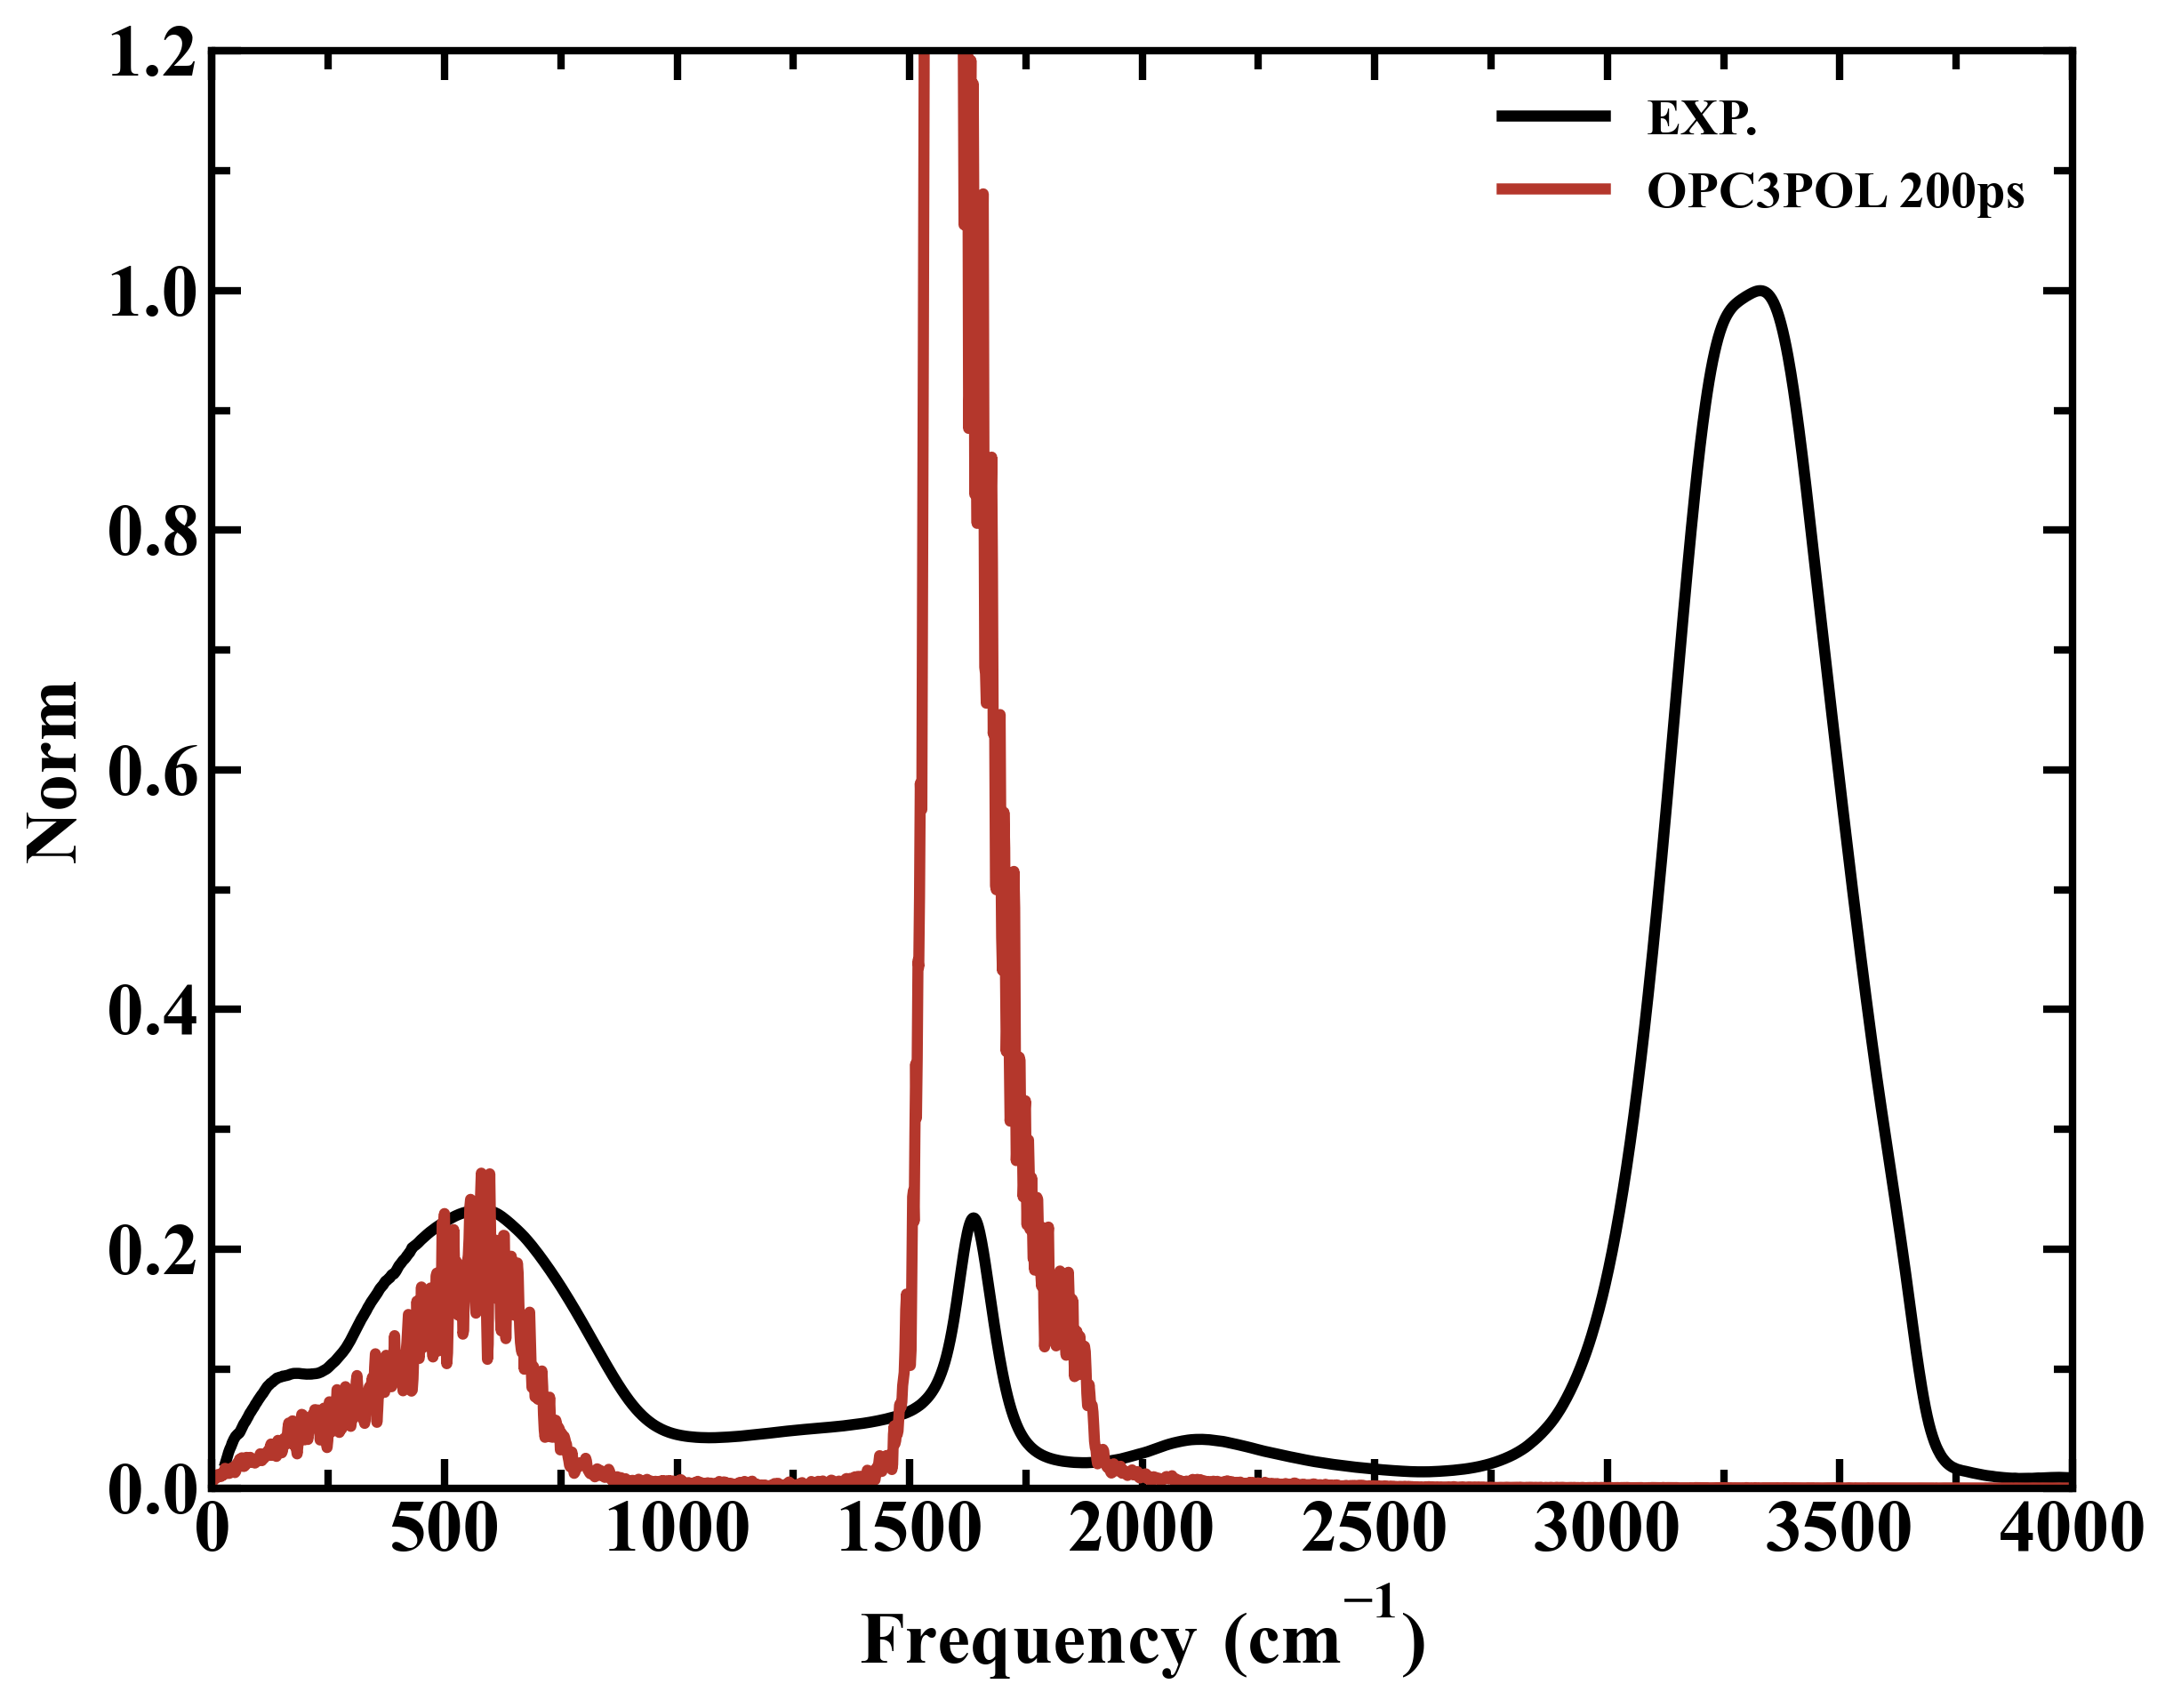

In [30]:
fig = plt.figure(figsize=(9,7),dpi=300)

plt.rcParams["axes.labelweight"] ="bold" 
plt.rcParams["font.family"]="Times New Roman" 
plt.rcParams["font.weight"]="bold" 
plt.rcParams["font.size"]=14 
plt.rcParams["mathtext.default"]="regular"

ax1= plt.gca()
ax1.spines['left'].set_position(('axes',0))
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.tick_params(which='major'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=8              # 设置长短
                    ,labelsize=20
 
                    )
ax1.tick_params(which='minor'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=5              # 设置长短
                    ,labelsize=20
           
                    )
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

c_s = ["#b4372c", "#cd8056", "#cfc282", "#bbd2cf", "#78a8c2", "#406d9c"]

exp_data_y_norm = (exp_data[:, 1] -exp_data[:, 1].min())/(exp_data[:, 1].max() - exp_data[:, 1].min())
ax1.plot(exp_data[:, 0], exp_data_y_norm
         , label="EXP."
         , c = "black"
         , alpha = 1,linewidth=3, linestyle = "-")          
# Iw_OPC3POL_200ps_hann[1].max()
Iw_OPC3POL_200ps_hann_norm = (Iw_OPC3POL_200ps_hann[1] -Iw_OPC3POL_200ps_hann[1].min())/(30 - Iw_OPC3POL_200ps_hann[1].min())
ax1.plot(Iw_OPC3POL_200ps_hann[0], Iw_OPC3POL_200ps_hann_norm
         , label="OPC3POL 200ps"
         , c = c_s[0]
         , alpha = 1,linewidth=3, linestyle = "-")  
plt.xlim([0, 4000])
plt.ylim([0, 1.2])
plt.legend(frameon=False, ncol=1)
plt.xlabel(r"$Frequency\ (cm^{-1})$", fontsize=20)
plt.ylabel(r"Norm", fontsize=20)
plt.savefig("4_opc3pol.png", dpi = 300)

# 加载TIP3P-rigid

## 200PS 
- 216 水分子

In [26]:
dt = 0.0005   # ps
if not os.path.exists('./out/tip3p_rigid_qv_3d_200ps.npy'):
    # 读取轨迹, 并计算qv
    fp_ncdf = "/home/iaw/DATA2/wat_md/bulk_tip3p_rigid/216/5_nvt_200ps/md200ps.ncdf"
    fp_top = "/home/iaw/DATA2/wat_md/bulk_tip3p_rigid/216/5_nvt_200ps/model.prmtop"
    start_frame = 0
    end_frame = 400000
    step = 1
    sele_mask = "type OW"
    O_charge = -0.8476
    H_charge = 0.4238

    n_worker = 10

    u = mda.Universe(fp_top,fp_ncdf, dt = dt)
    print("All number of frames is {}, and the timestep is {:.4f} ps, and the simulation time is {:.4f} ns".format(len(u.trajectory)
                                , u.trajectory.dt
                                , len(u.trajectory) * u.trajectory.dt / 1000))
    
    def get_QV(i_frame, u, sele_mask, O_charge = False, H_charge = False):

        total_u_ = np.zeros(shape=(3,))

        i_traj = u.trajectory[i_frame]
        i_v = i_traj.velocities
        seles = u.select_atoms(sele_mask) 

        # 这里是取巧, 水分子储存的时候是按照顺序
        ow_idx = seles.indices
        hw1_idx = seles.indices+1
        hw2_idx = seles.indices+2

        #n_atm, 3 -> 3, 1
        qv_ow = i_v[ow_idx].sum(axis = 0)*O_charge
        qv_hw1 = i_v[hw1_idx].sum(axis = 0)*H_charge
        qv_hw2 = i_v[hw2_idx].sum(axis = 0)*H_charge

        total_u_ += (qv_ow + qv_hw1 + qv_hw2 )
        return total_u_

    single_frame = partial(get_QV
                , u = u
                , sele_mask = sele_mask
                , O_charge = O_charge, H_charge = H_charge)
    
    frames = list(range(start_frame,end_frame,step))

    # 这种任务, 实际上并行的效率并不是很高, 一定要注意内存
    with Pool(n_worker) as worker_pool:
        result = worker_pool.map(single_frame, frames)

    qv_s_total = np.stack(result, axis = 0)
    print(qv_s_total.shape)
    np.save('./out/tip3p_rigid_qv_3d_200ps.npy', qv_s_total, allow_pickle=True)

qv_s_total = np.load("./out/tip3p_rigid_qv_3d_200ps.npy")
C_qv = auto_corr_fft(qv_s_total, fraction_autocorrelation_function_to_fft = 0.1)
tau = np.array(np.array(list(range(C_qv.shape[0])), dtype=np.float64))
tau *= dt                   # ps
# save
with open("./out/qv_autocorr_out_tip3p_rigid_200ps.csv", "w+") as F:
    for i, i_x in enumerate(tau):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, C_qv[i]))
qv_autocorr_tip3p_rigid_200ps = np.loadtxt("./out/qv_autocorr_out_tip3p_rigid_200ps.csv",delimiter=",")
qv_autocorr_tip3p_rigid_200ps_hann = auto_corr_hann(qv_autocorr_tip3p_rigid_200ps[:,1])
Iw_tip3p_rigid_200ps_hann = fft_to_Iw(qv_autocorr_tip3p_rigid_200ps[:,0], qv_autocorr_tip3p_rigid_200ps_hann)


In [27]:
x, y9 = Iw_tip3p_rigid_200ps_hann
with open("./out/ir-tip3p-200ps.csv", "w+") as F:
    F.writelines("Freq, Iw(200ps, hann)\n")
    for i, i_x in enumerate(x):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, y9[i]))


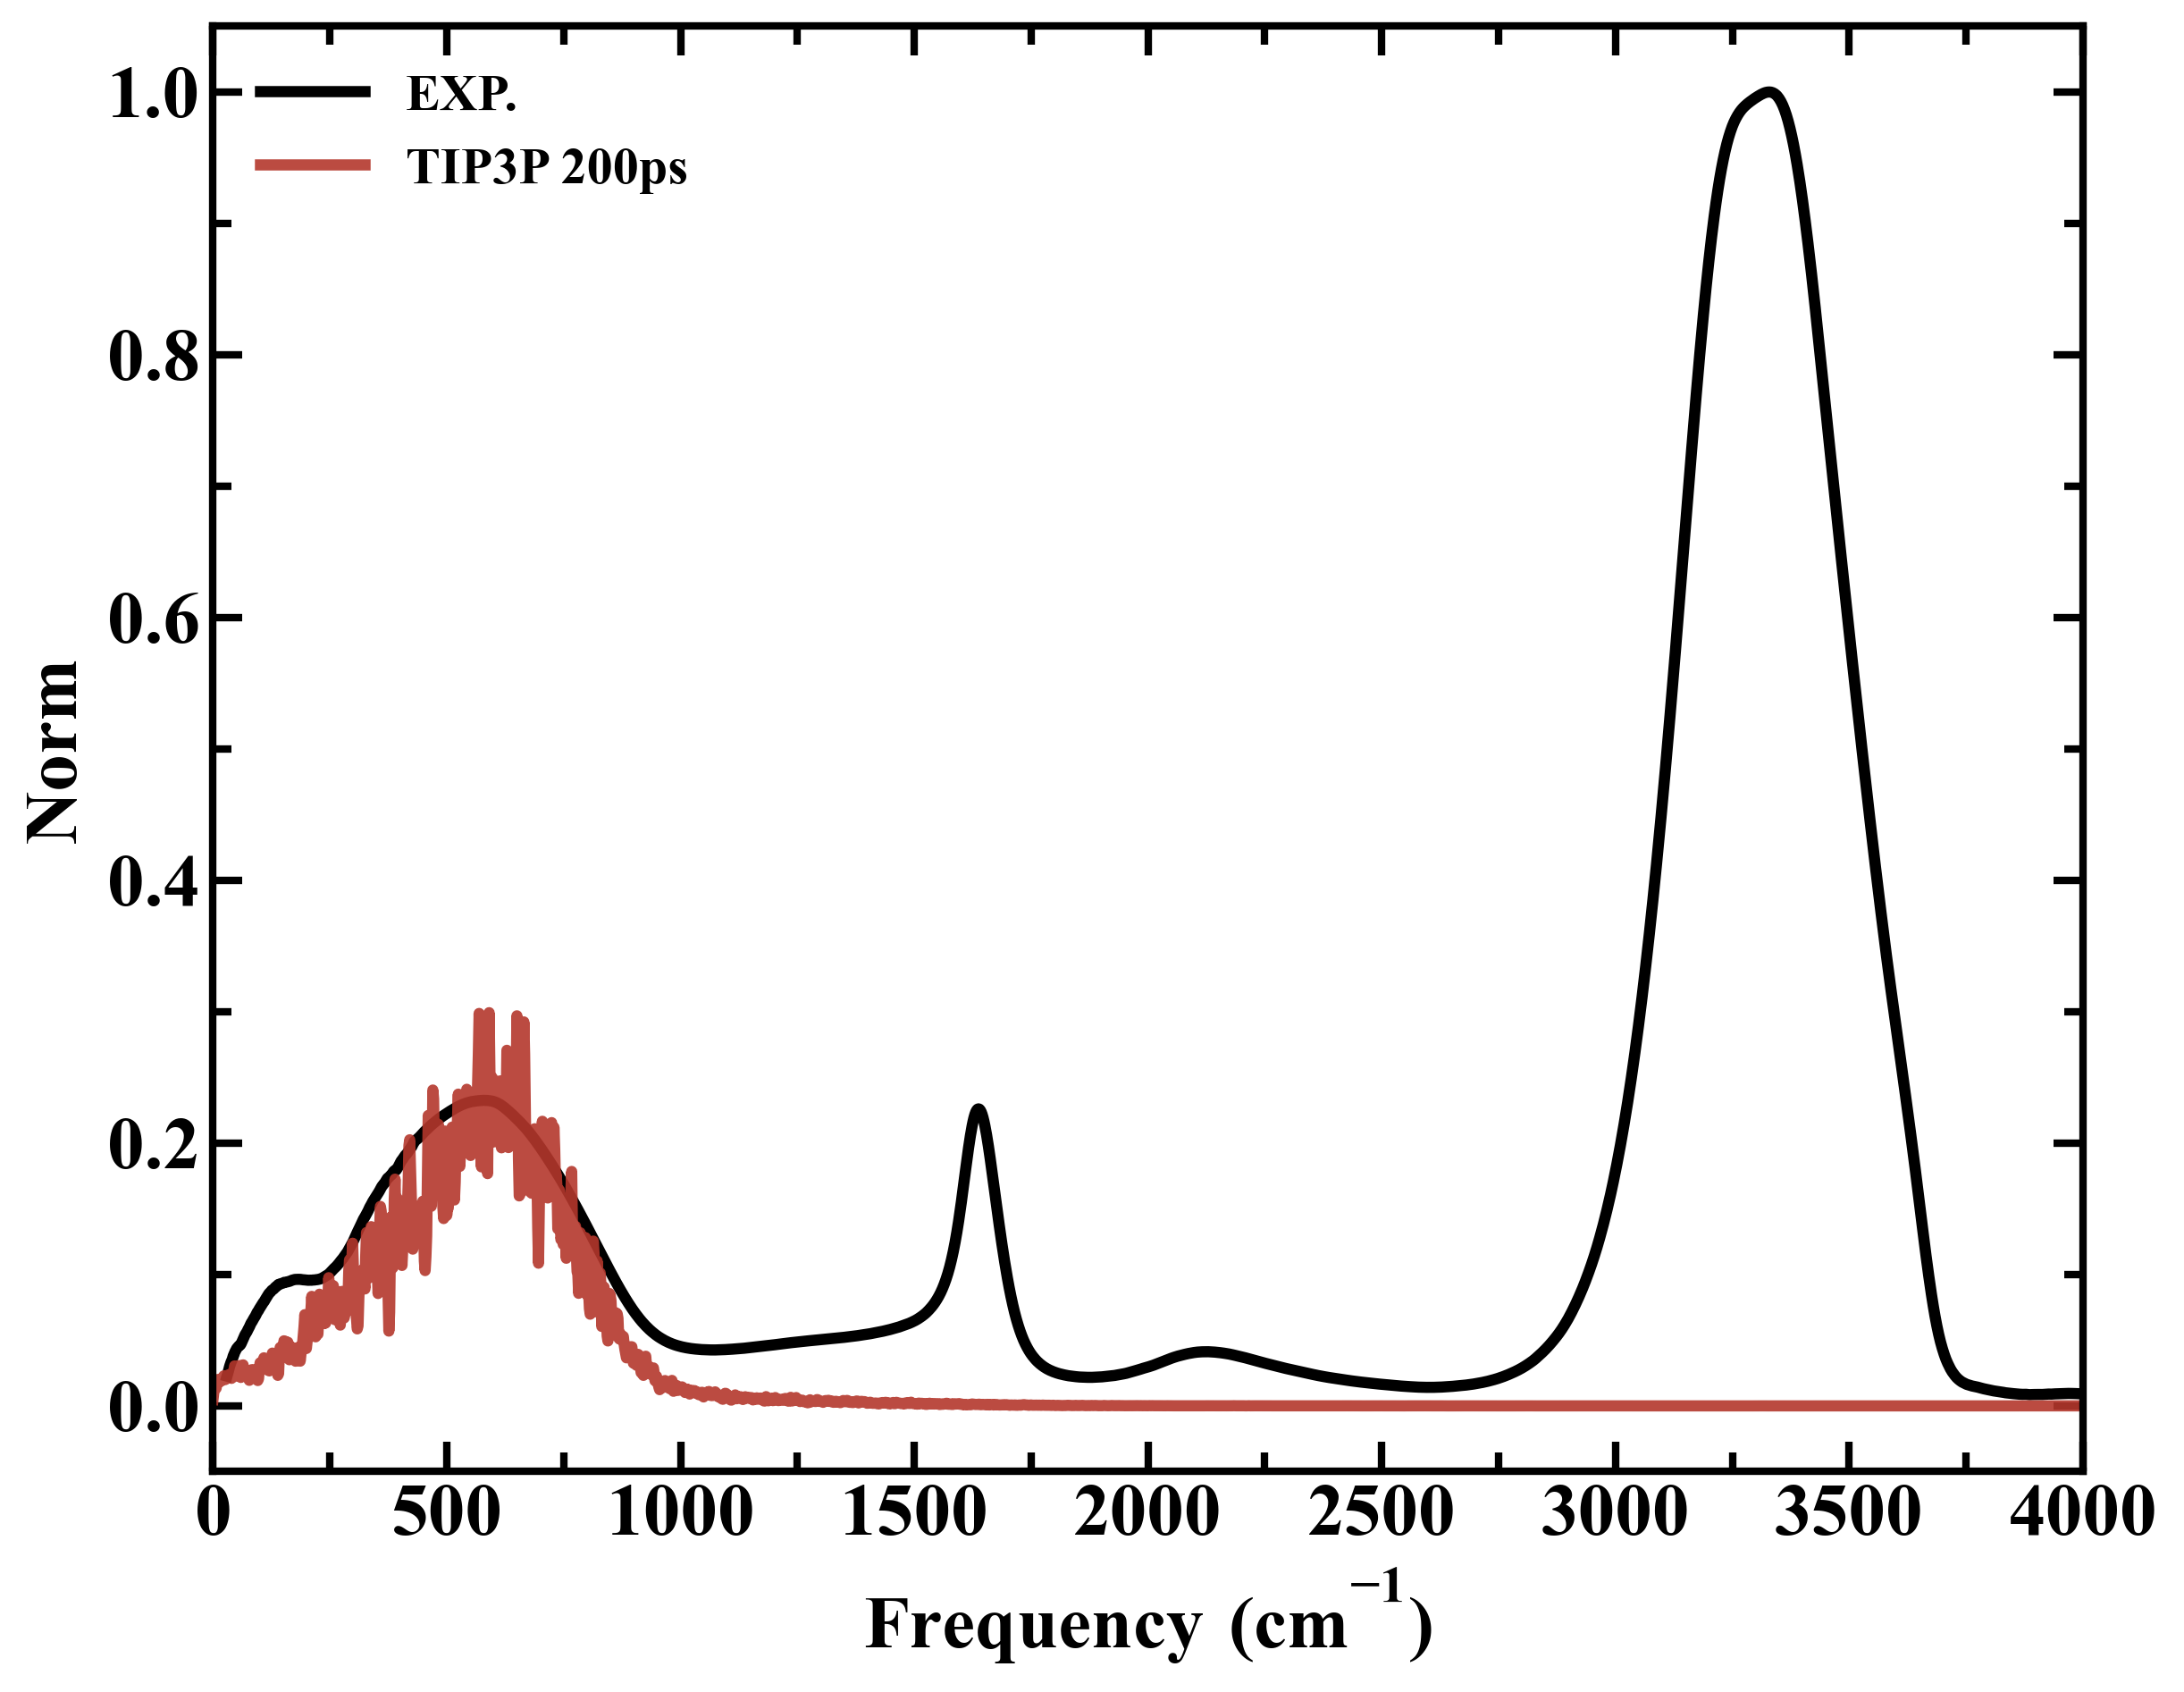

In [43]:
fig = plt.figure(figsize=(9,7),dpi=300)

plt.rcParams["axes.labelweight"] ="bold" 
plt.rcParams["font.family"]="Times New Roman" 
plt.rcParams["font.weight"]="bold" 
plt.rcParams["font.size"]=14 
plt.rcParams["mathtext.default"]="regular"

ax1= plt.gca()
ax1.spines['left'].set_position(('axes',0))
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.tick_params(which='major'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=8              # 设置长短
                    ,labelsize=20
 
                    )
ax1.tick_params(which='minor'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=5              # 设置长短
                    ,labelsize=20
           
                    )
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

c_s = ["#b4372c", "#cd8056", "#cfc282", "#bbd2cf", "#78a8c2", "#406d9c"]

exp_data_y_norm = (exp_data[:, 1] -exp_data[:, 1].min())/(exp_data[:, 1].max() - exp_data[:, 1].min())
ax1.plot(exp_data[:, 0], exp_data_y_norm
         , label="EXP."
         , c = "black"
         , alpha = 1,linewidth=3, linestyle = "-")          

Iw_tip3p_rigid_200ps_hann_norm = (Iw_tip3p_rigid_200ps_hann[1] -Iw_tip3p_rigid_200ps_hann[1].min())/(150- Iw_tip3p_rigid_200ps_hann[1].min())
ax1.plot(Iw_tip3p_rigid_200ps_hann[0], Iw_tip3p_rigid_200ps_hann_norm
         , label="TIP3P 200ps"
         , c = c_s[0]
         , alpha = 0.9,linewidth=3, linestyle = "-")  
plt.xlim([0, 4000])

plt.legend(frameon=False, ncol=1)
plt.xlabel(r"$Frequency\ (cm^{-1})$", fontsize=20)
plt.ylabel(r"Norm", fontsize=20)
plt.savefig("5_tip3p.png", dpi = 300)

# 加载SPCE-rigid

## 细节
- rigid

## 200ps

In [28]:
dt = 0.0005   # ps
if not os.path.exists('./out/spce_rigid_qv_3d_200ps.npy'):
    # 读取轨迹, 并计算qv
    fp_ncdf = "/home/iaw/DATA2/wat_md/bulk_spce_rigid/nvt_200ps/md200ps.ncdf"
    fp_top = "/home/iaw/DATA2/wat_md/bulk_spce_rigid/nvt_200ps/model.prmtop"
    start_frame = 0
    end_frame = 400000
    step = 1
    sele_mask = "type OW"
    O_charge = -0.8476
    H_charge = 0.4238

    n_worker = 10

    u = mda.Universe(fp_top,fp_ncdf, dt = dt)
    print("All number of frames is {}, and the timestep is {:.4f} ps, and the simulation time is {:.4f} ns".format(len(u.trajectory)
                                , u.trajectory.dt
                                , len(u.trajectory) * u.trajectory.dt / 1000))
    
    def get_QV(i_frame, u, sele_mask, O_charge = False, H_charge = False):

        total_u_ = np.zeros(shape=(3,))

        i_traj = u.trajectory[i_frame]
        i_v = i_traj.velocities
        seles = u.select_atoms(sele_mask) 

        # 这里是取巧, 水分子储存的时候是按照顺序
        ow_idx = seles.indices
        hw1_idx = seles.indices+1
        hw2_idx = seles.indices+2

        #n_atm, 3 -> 3, 1
        qv_ow = i_v[ow_idx].sum(axis = 0)*O_charge
        qv_hw1 = i_v[hw1_idx].sum(axis = 0)*H_charge
        qv_hw2 = i_v[hw2_idx].sum(axis = 0)*H_charge

        total_u_ += (qv_ow + qv_hw1 + qv_hw2 )
        return total_u_

    single_frame = partial(get_QV
                , u = u
                , sele_mask = sele_mask
                , O_charge = O_charge, H_charge = H_charge)
    
    frames = list(range(start_frame,end_frame,step))

    # 这种任务, 实际上并行的效率并不是很高, 一定要注意内存
    with Pool(n_worker) as worker_pool:
        result = worker_pool.map(single_frame, frames)

    qv_s_total = np.stack(result, axis = 0)
    print(qv_s_total.shape)
    np.save('./out/spce_rigid_qv_3d_200ps.npy', qv_s_total, allow_pickle=True)

qv_s_total = np.load("./out/spce_rigid_qv_3d_200ps.npy")
C_qv = auto_corr_fft(qv_s_total, fraction_autocorrelation_function_to_fft = 0.1)
tau = np.array(np.array(list(range(C_qv.shape[0])), dtype=np.float64))
tau *= dt                   # ps
# save
with open("./out/qv_autocorr_out_spce_rigid_200ps.csv", "w+") as F:
    for i, i_x in enumerate(tau):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, C_qv[i]))
qv_autocorr_spce_rigid_200ps = np.loadtxt("./out/qv_autocorr_out_spce_rigid_200ps.csv",delimiter=",")
qv_autocorr_spce_rigid_200ps_hann = auto_corr_hann(qv_autocorr_spce_rigid_200ps[:,1])
Iw_spce_rigid_200ps_hann = fft_to_Iw(qv_autocorr_spce_rigid_200ps[:,0], qv_autocorr_spce_rigid_200ps_hann)


In [29]:
x, y10 = Iw_spce_rigid_200ps_hann
with open("./out/ir-spce_rigid-200ps.csv", "w+") as F:
    F.writelines("Freq, Iw(200ps, hann)\n")
    for i, i_x in enumerate(x):
        F.writelines("{:.6f}, {:.6f}\n".format(i_x, y10[i]))


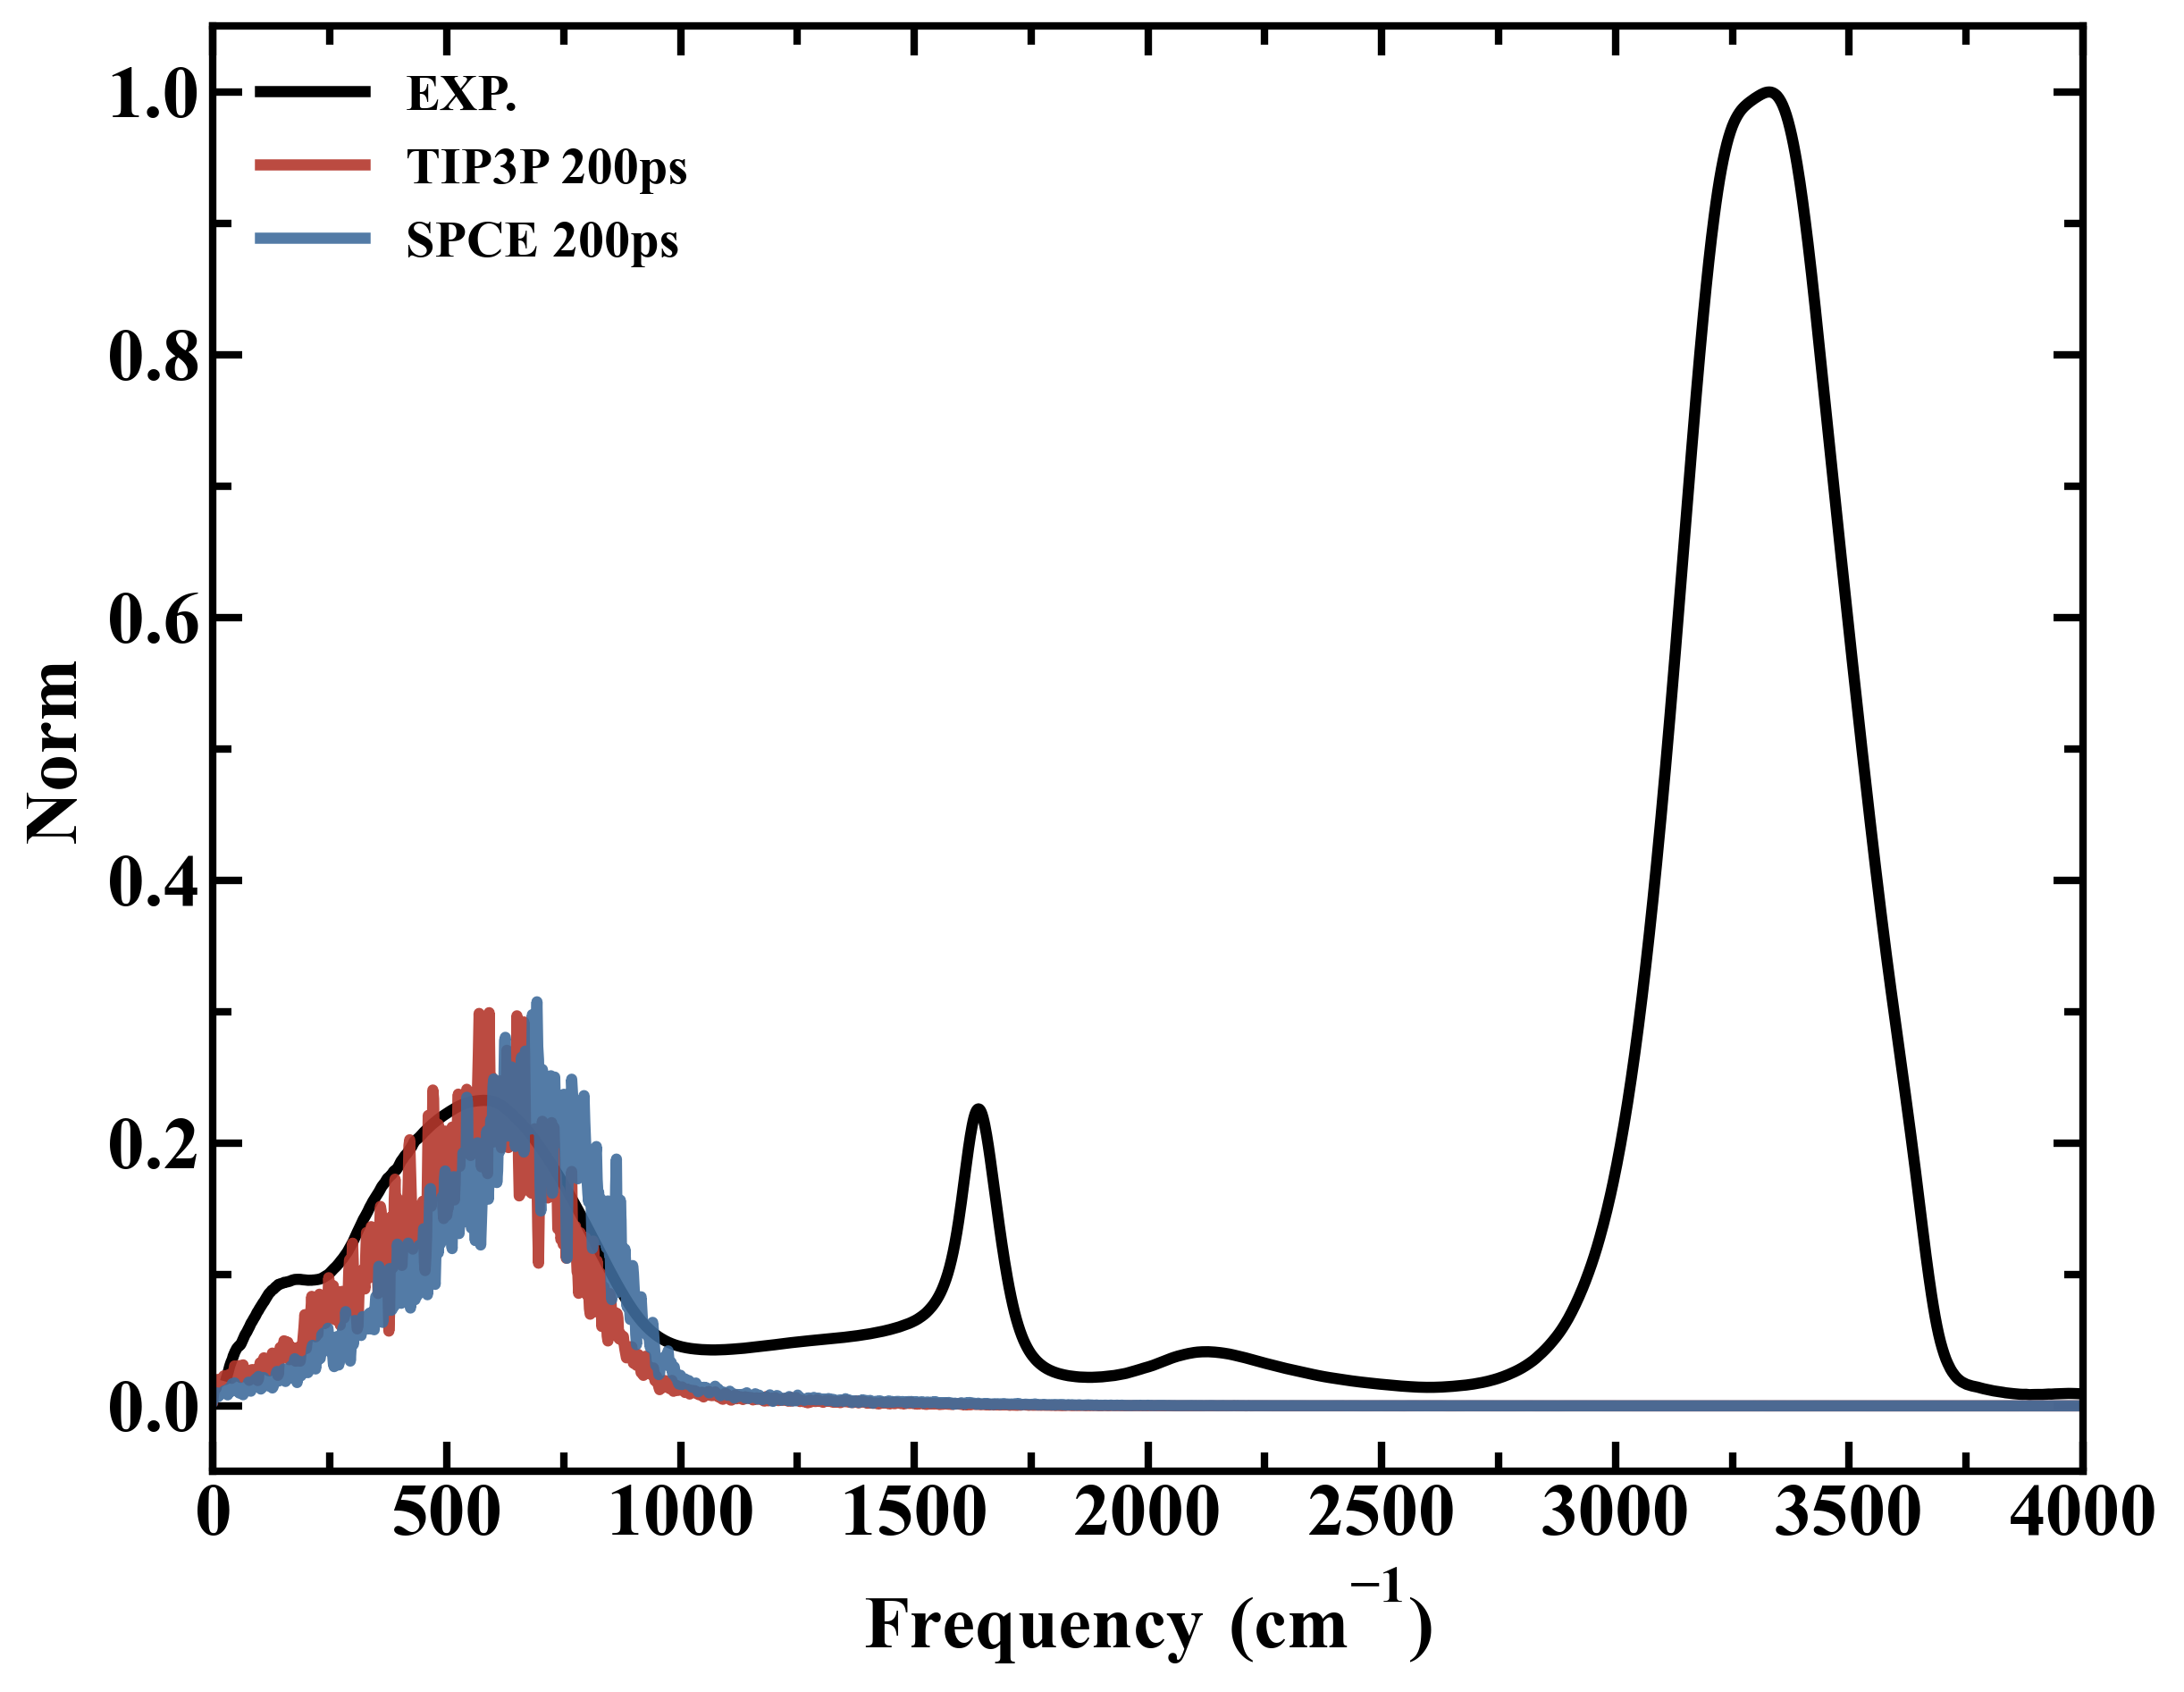

In [47]:
fig = plt.figure(figsize=(9,7),dpi=300)

plt.rcParams["axes.labelweight"] ="bold" 
plt.rcParams["font.family"]="Times New Roman" 
plt.rcParams["font.weight"]="bold" 
plt.rcParams["font.size"]=14 
plt.rcParams["mathtext.default"]="regular"

ax1= plt.gca()
ax1.spines['left'].set_position(('axes',0))
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.tick_params(which='major'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=8              # 设置长短
                    ,labelsize=20
 
                    )
ax1.tick_params(which='minor'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=5              # 设置长短
                    ,labelsize=20
           
                    )
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

c_s = ["#b4372c", "#cd8056", "#cfc282", "#bbd2cf", "#78a8c2", "#406d9c"]

exp_data_y_norm = (exp_data[:, 1] -exp_data[:, 1].min())/(exp_data[:, 1].max() - exp_data[:, 1].min())
ax1.plot(exp_data[:, 0], exp_data_y_norm
         , label="EXP."
         , c = "black"
         , alpha = 1,linewidth=3, linestyle = "-")          

Iw_tip3p_rigid_200ps_hann_norm = (Iw_tip3p_rigid_200ps_hann[1] -Iw_tip3p_rigid_200ps_hann[1].min())/(150- Iw_tip3p_rigid_200ps_hann[1].min())
ax1.plot(Iw_tip3p_rigid_200ps_hann[0], Iw_tip3p_rigid_200ps_hann_norm
         , label="TIP3P 200ps"
         , c = c_s[0]
         , alpha = 0.9,linewidth=3, linestyle = "-")  

Iw_spce_rigid_200ps_hann_norm = (Iw_spce_rigid_200ps_hann[1] -Iw_spce_rigid_200ps_hann[1].min())/(150- Iw_spce_rigid_200ps_hann[1].min())
ax1.plot(Iw_spce_rigid_200ps_hann[0], Iw_spce_rigid_200ps_hann_norm
         , label="SPCE 200ps"
         , c = c_s[-1]
         , alpha = 0.9,linewidth=3, linestyle = "-")  

plt.xlim([0, 4000])

plt.legend(frameon=False, ncol=1)
plt.xlabel(r"$Frequency\ (cm^{-1})$", fontsize=20)
plt.ylabel(r"Norm", fontsize=20)
plt.savefig("6_tip3p_spce_rigid.png", dpi = 300)

In [48]:
from scipy.signal import savgol_filter

In [65]:
Iw_pbe_45ps_hann_smo = savgol_filter(Iw_pbe_45ps_hann[1], 31, 2, mode="nearest")
Iw_SPCE_200ps_hann_smo = savgol_filter(Iw_SPCE_200ps_hann[1], 31, 2, mode="nearest")
#Iw_OPC3POL_200ps_hann_smo = savgol_filter(Iw_OPC3POL_200ps_hann[1], 35, 2, mode="nearest")


In [138]:
Iw_OPC3POL_200ps_hann_smo.max(), Iw_OPC3POL_200ps_hann_smo.min()

(211.05448093434006, 0.16750446441184774)

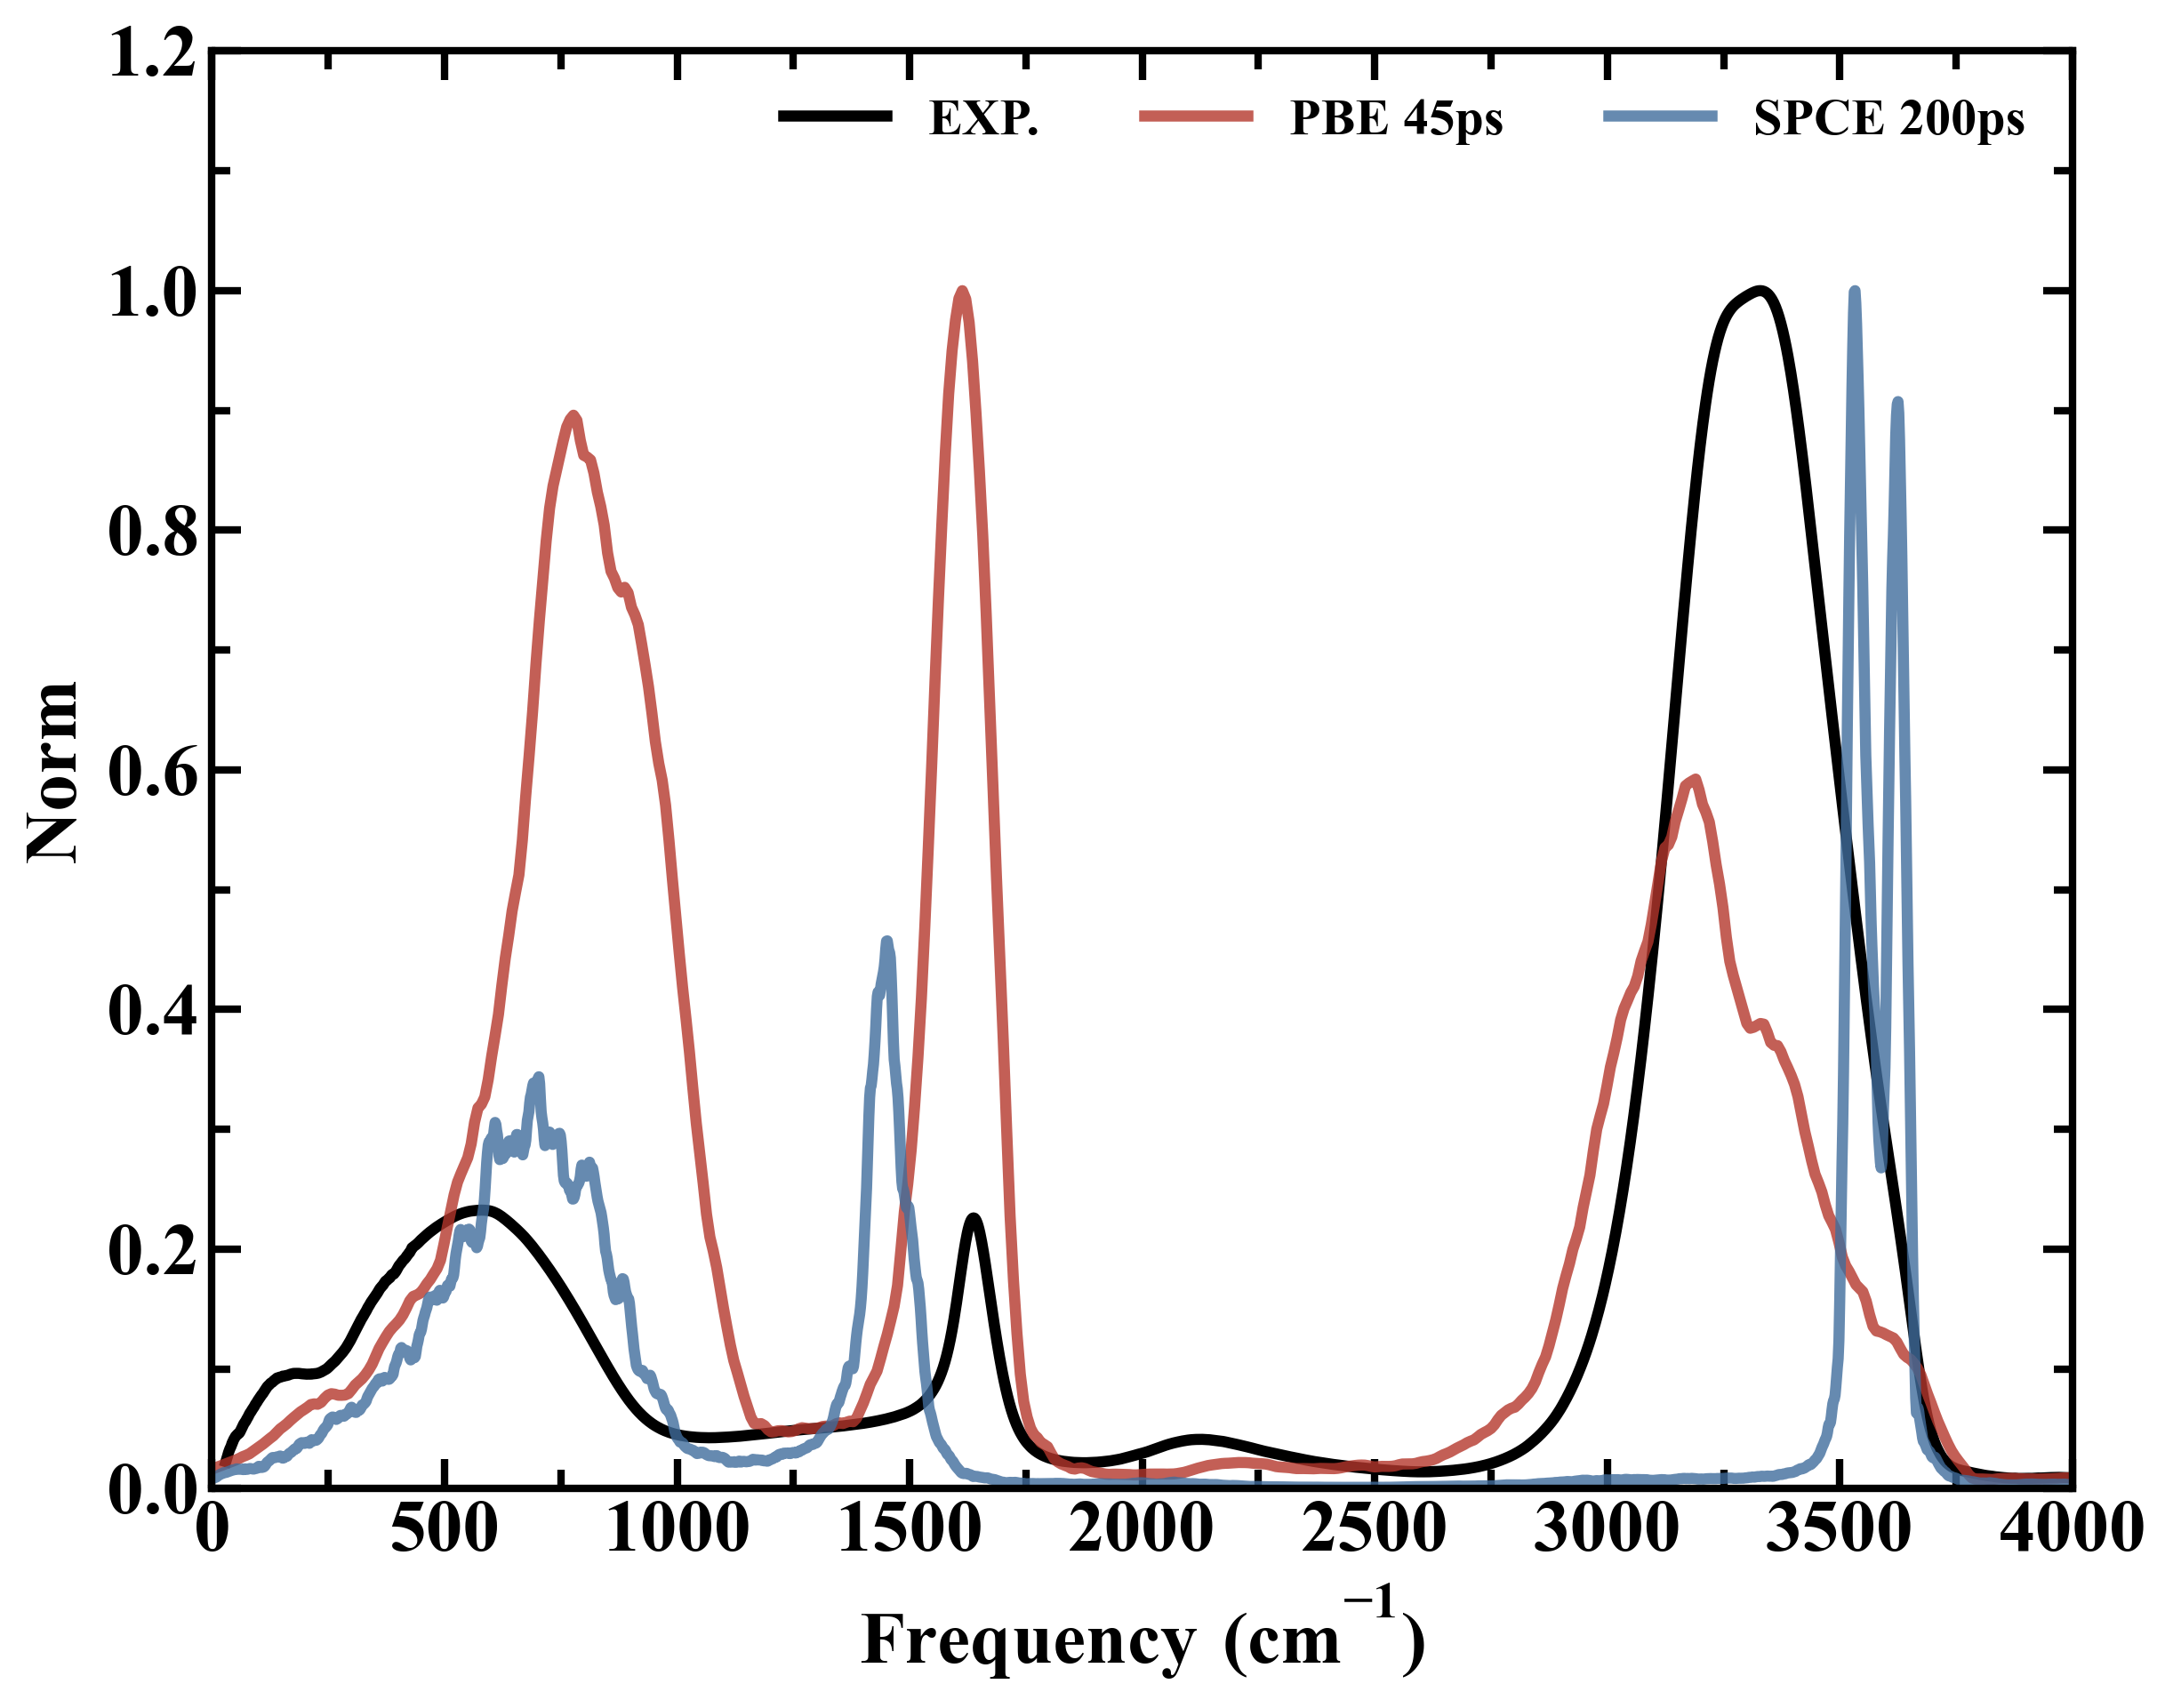

In [69]:
fig = plt.figure(figsize=(9,7),dpi=300)

plt.rcParams["axes.labelweight"] ="bold" 
plt.rcParams["font.family"]="Times New Roman" 
plt.rcParams["font.weight"]="bold" 
plt.rcParams["font.size"]=14 
plt.rcParams["mathtext.default"]="regular"

ax1= plt.gca()
ax1.spines['left'].set_position(('axes',0))
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.tick_params(which='major'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=8              # 设置长短
                    ,labelsize=20
 
                    )
ax1.tick_params(which='minor'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=5              # 设置长短
                    ,labelsize=20
           
                    )
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

c_s = ["#b4372c", "#cd8056", "#cfc282", "#bbd2cf", "#78a8c2", "#406d9c"]

exp_data_y_norm = (exp_data[:, 1] -exp_data[:, 1].min())/(exp_data[:, 1].max() - exp_data[:, 1].min())
ax1.plot(exp_data[:, 0], exp_data_y_norm
         , label="EXP."
         , c = "black"
         , alpha = 1,linewidth=3, linestyle = "-")  

Iw_pbe_45ps_hann_smo_norm = (Iw_pbe_45ps_hann_smo -Iw_pbe_45ps_hann_smo.min())/(Iw_pbe_45ps_hann_smo.max() - Iw_pbe_45ps_hann_smo.min())
ax1.plot(Iw_pbe_45ps_hann[0], Iw_pbe_45ps_hann_smo_norm
         , label="PBE 45ps"
         , c = c_s[0]
         , alpha = 0.8,linewidth=3, linestyle = "-")  

Iw_SPCE_200ps_hann_smo_norm = (Iw_SPCE_200ps_hann_smo -Iw_SPCE_200ps_hann_smo.min())/(Iw_SPCE_200ps_hann_smo.max() - Iw_SPCE_200ps_hann_smo.min())
ax1.plot(Iw_SPCE_200ps_hann[0], Iw_SPCE_200ps_hann_smo_norm
         , label="SPCE 200ps"
         , c = c_s[-1]
         , alpha = 0.8,linewidth=3, linestyle = "-")  

plt.ylim([0, 1.2])
plt.xlim([0, 4000])

plt.legend(frameon=False, ncol=3)
plt.xlabel(r"$Frequency\ (cm^{-1})$", fontsize=20)
plt.ylabel(r"Norm", fontsize=20)
plt.savefig("./7_savgol_filter.png", dpi = 300)

# 高斯展宽

In [67]:
# 高斯展宽
def gaussian_broadening(freq, spectrum, hwhm, max_freq=5000):
    # 初始化展宽后的光谱
    broadened_spectrum = np.zeros(max_freq + 1)
    gaussian =  lambda freq, center, hwhm: np.exp(-np.log(2.0) / hwhm**2 * (freq - center)**2)
    for i in range(len(freq)):
        center = int(freq[i])
        # 遍历高斯展宽范围
        for j in range(-3 * hwhm, 3 * hwhm + 1):
            current_freq = center + j
            if 0 <= current_freq <= max_freq:
                # 计算高斯函数值并累加到展宽光谱
                broadened_spectrum[current_freq] += spectrum[i] * gaussian(current_freq, center, hwhm)
    
    return broadened_spectrum

In [68]:
Iw_pbe_45ps_hann_g_broad = gaussian_broadening(Iw_pbe_45ps_hann[0], Iw_pbe_45ps_hann[1], 30)
Iw_SPCE_200ps_hann_g_broad = gaussian_broadening(Iw_SPCE_200ps_hann[0], Iw_SPCE_200ps_hann[1], 30)

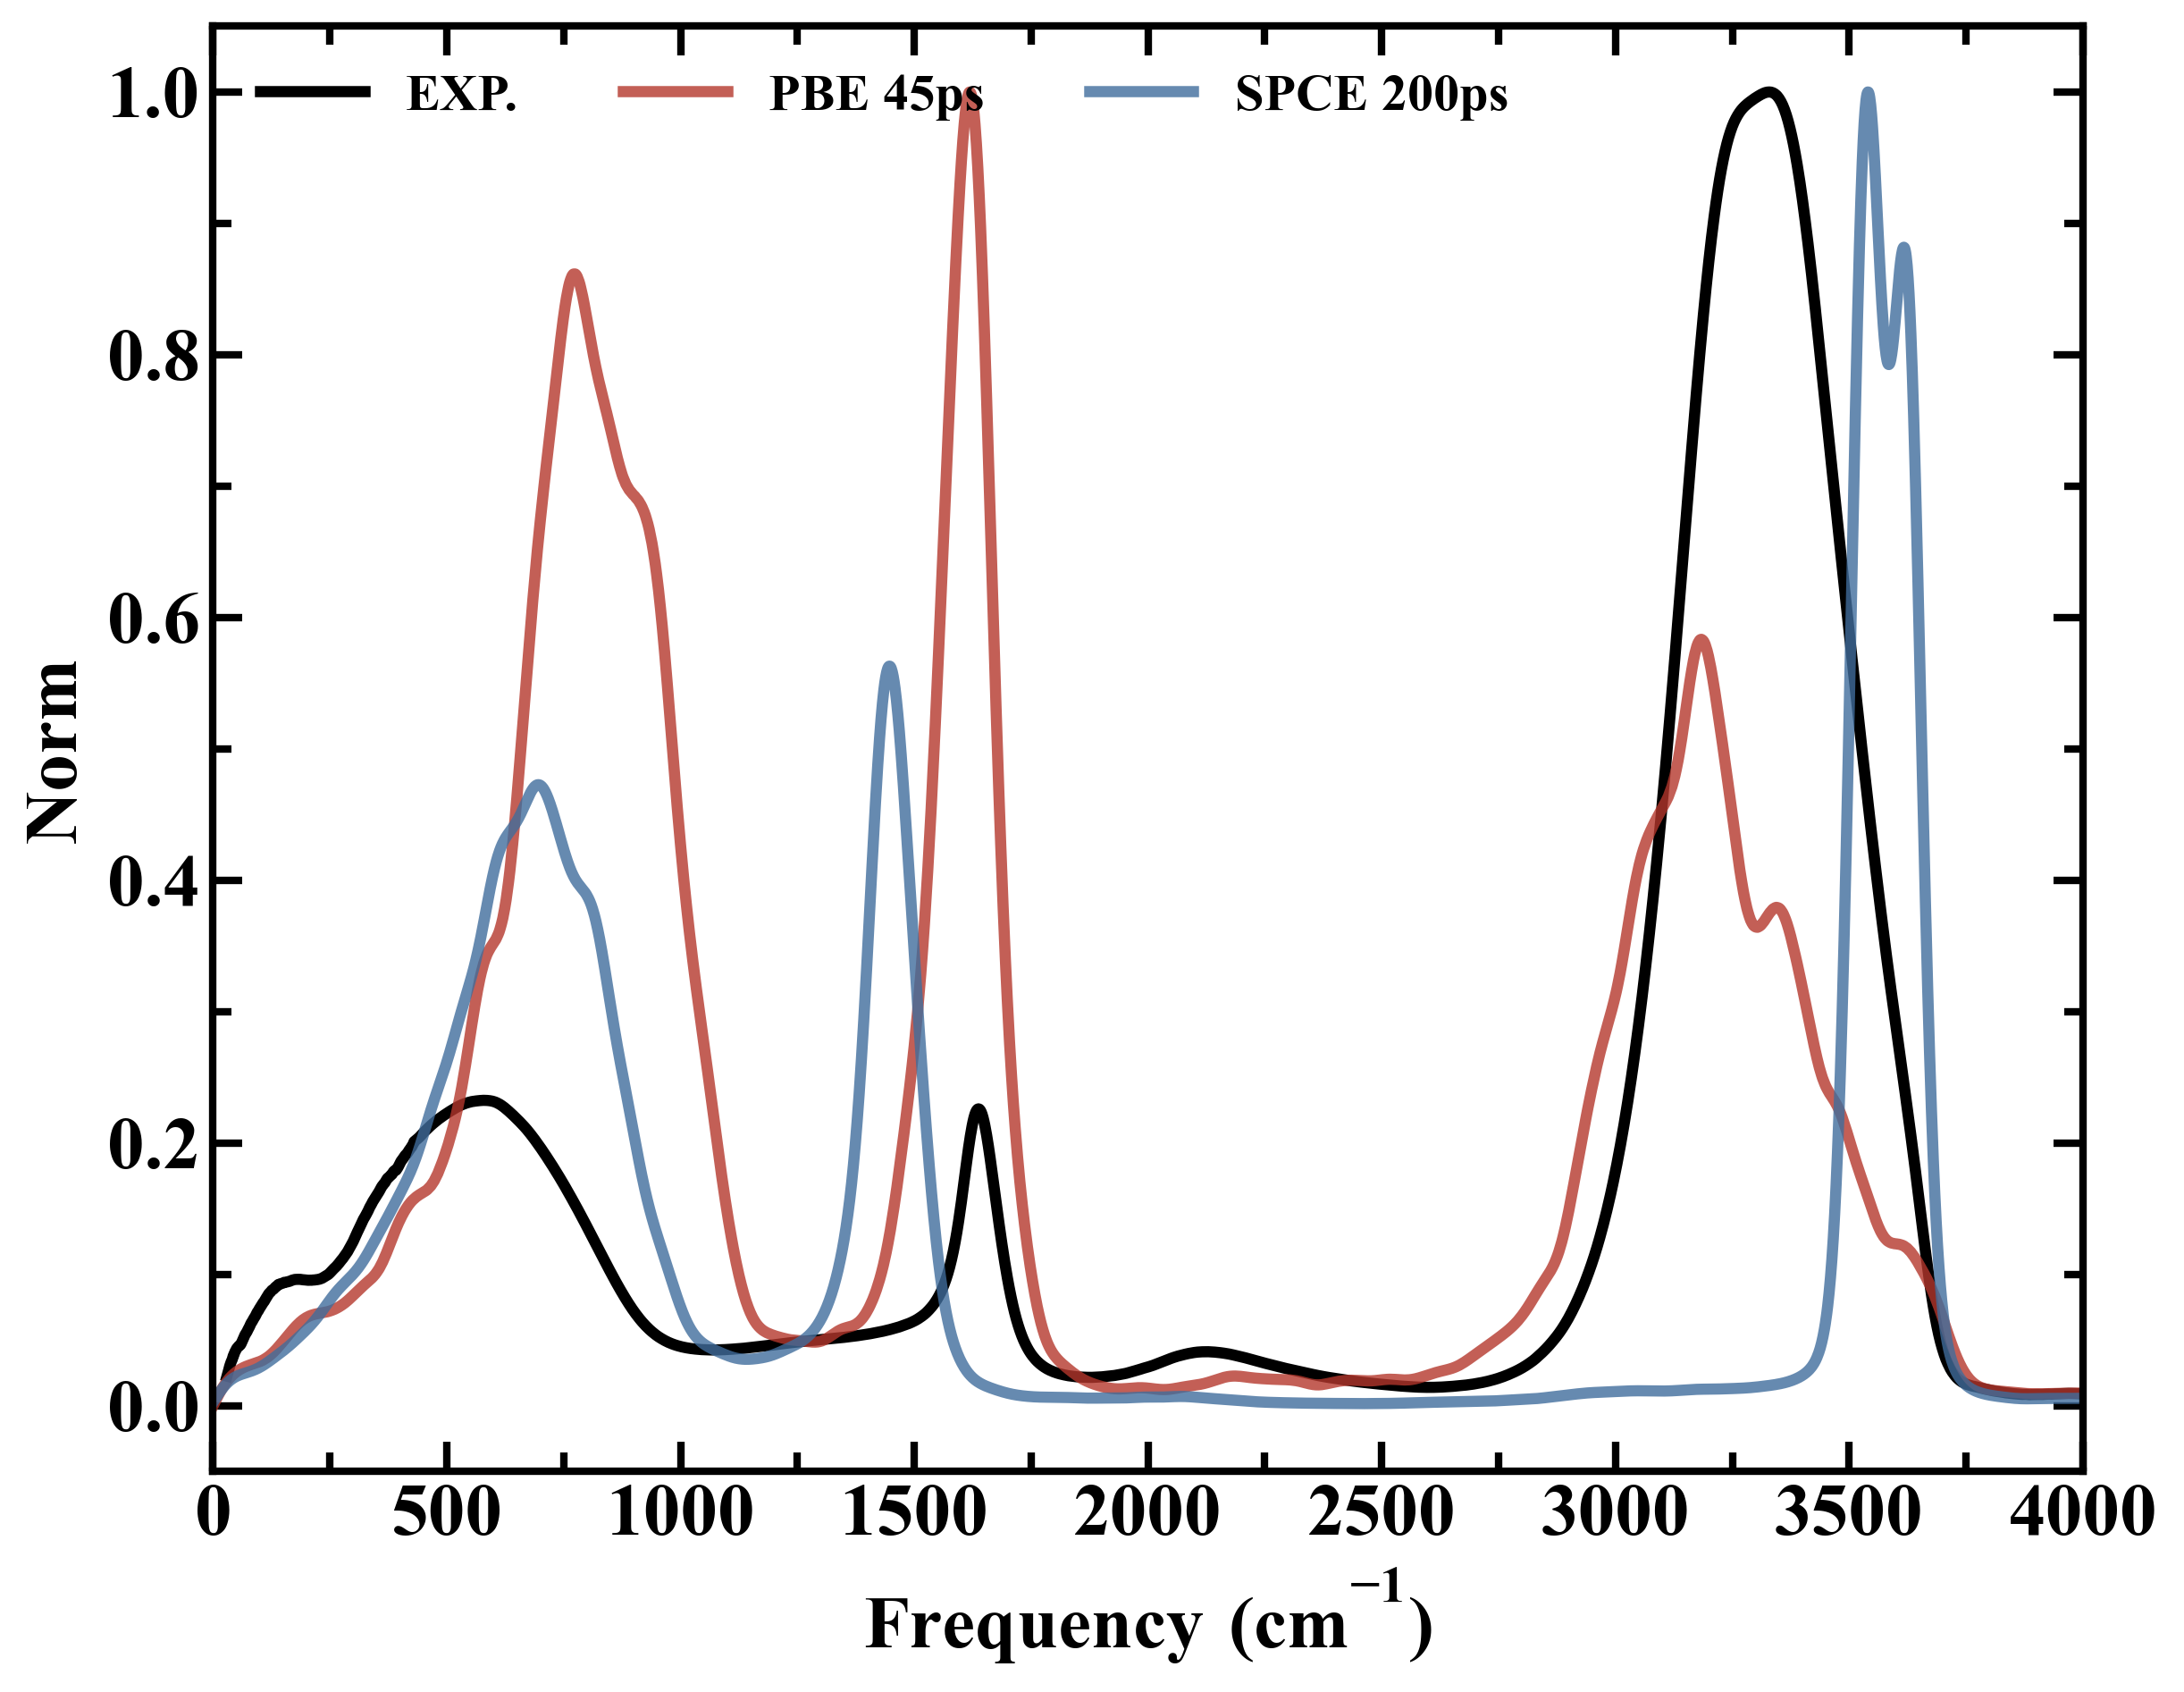

In [70]:
fig = plt.figure(figsize=(9,7),dpi=300)

plt.rcParams["axes.labelweight"] ="bold" 
plt.rcParams["font.family"]="Times New Roman" 
plt.rcParams["font.weight"]="bold" 
plt.rcParams["font.size"]=14 
plt.rcParams["mathtext.default"]="regular"

ax1= plt.gca()
ax1.spines['left'].set_position(('axes',0))
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.tick_params(which='major'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=8              # 设置长短
                    ,labelsize=20
 
                    )
ax1.tick_params(which='minor'          # 设置对主刻度和次刻度生效
                    ,bottom=True           # 底部坐标轴
                    ,left=True             # 左侧坐标轴
                    , right = True
                    , top = True
                    ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                    ,width=2               # 设置刻度线粗细
                    ,length=5              # 设置长短
                    ,labelsize=20
           
                    )
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

c_s = ["#b4372c", "#cd8056", "#cfc282", "#bbd2cf", "#78a8c2", "#406d9c"]

exp_data_y_norm = (exp_data[:, 1] -exp_data[:, 1].min())/(exp_data[:, 1].max() - exp_data[:, 1].min())
ax1.plot(exp_data[:, 0], exp_data_y_norm
         , label="EXP."
         , c = "black"
         , alpha = 1,linewidth=3, linestyle = "-")  

Iw_pbe_45ps_hann_g_broad_norm = (Iw_pbe_45ps_hann_g_broad -Iw_pbe_45ps_hann_g_broad.min())/(Iw_pbe_45ps_hann_g_broad.max() - Iw_pbe_45ps_hann_g_broad.min())
ax1.plot(np.arange(5001), Iw_pbe_45ps_hann_g_broad_norm
         , label="PBE 45ps"
         , c = c_s[0]
         , alpha = 0.8,linewidth=3, linestyle = "-")  

Iw_SPCE_200ps_hann_g_broad_norm = (Iw_SPCE_200ps_hann_g_broad -Iw_SPCE_200ps_hann_g_broad.min())/(Iw_SPCE_200ps_hann_g_broad.max() - Iw_SPCE_200ps_hann_g_broad.min())
ax1.plot(np.arange(5001), Iw_SPCE_200ps_hann_g_broad_norm
         , label="SPCE 200ps"
         , c = c_s[-1]
         , alpha = 0.8,linewidth=3, linestyle = "-")  

plt.xlim([0, 4000])

plt.legend(frameon=False, ncol=3)
plt.xlabel(r"$Frequency\ (cm^{-1})$", fontsize=20)
plt.ylabel(r"Norm", fontsize=20)
plt.savefig("./8_g_broad.png", dpi = 300)